# ADA Project: 2018's Best Hit Recipe 🎙🎵

The Million Song Dataset is a collaboration between the LabROSA and The Echo Nest, which includes audio features and metadata for a million popular western music tracks.
The whole dataset, about 280 GB, was released in 2011, and is freely available. 

Documentation about the Million Song Dataset can be found at the official website: 
https://labrosa.ee.columbia.edu/millionsong/

For this second milestone, we used the Million Song Dataset subset, which contains only 10 000 songs (~ 2.5 GB uncompressed).
This way, we could perform the analysis locally and get started more quickly.

### An Example Track Description

We provide the link to the *Example Track Description* from the Million Song Dataset documentation, of the track with `track id` TRAXLZU12903D05F94 ("Never Gonna Give You Up" by Rick Astle).
This way, one can quickly lookup the meaning of a particular field.

https://labrosa.ee.columbia.edu/millionsong/pages/example-track-description

In [1]:
import numpy as np
import pandas as pd

import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

import os
import glob
import time

import csv
import json

import folium

import h5py
import hdf5_getters
from hdf5_getters import *

from operator import methodcaller

In [2]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource, show
from bokeh.models import HoverTool, PanTool, BoxZoomTool, WheelZoomTool, ZoomInTool, ZoomOutTool, Title
from bokeh.models.tickers import FixedTicker
from bokeh.models.formatters import FuncTickFormatter
output_notebook()

Loading BokehJS ...

We use two code snippets from the LabROSA, as well as the `hdf5_getters.py` Python wrapper, which contains method for reading an HDF5 file and accessing its fields.

The code of the `hdf5_getters.py` can be found at:

https://github.com/tbertinmahieux/MSongsDB/blob/master/PythonSrc/hdf5_getters.py

In [3]:
def count_all_files(base_directory, ext='.h5') :
    cnt = 0
    for root, dirs, files in os.walk(base_directory):
        files = glob.glob(os.path.join(root,'*'+ext))
        cnt += len(files)
    return cnt

In [4]:
def get_all(getter, base_directory, ext='.h5'):
    values = []
    for root, dirs, files in os.walk(base_directory):
        files = glob.glob(os.path.join(root,'*'+ext))
        for f in files:
            h5 = hdf5_getters.open_h5_file_read(f)
            values.append( getter(h5) )
            h5.close()
    return values

Additionally, the following method can be used to extract all fields of a song, song by song.
When reading the whole MSD subset, it is more efficient to access all fields of a song, rather than accessing a certain field for all songs. 
This is because in the first case, the HDF5 files have to be opened only once, while in the second case, each HDF5 file has to be read as many times as there are fields.

In [5]:
def get_file_fields(file, all_getters):
    fields = []
    for getter_name in all_getters:
        getter = getattr(hdf5_getters, getter_name)
        fields.append(getter(h5))
    return fields

We can check the dataset can be correctly accessed by counting the number of files for instance.

In [3]:
# the path to the Million Song Dataset subset
base_directory = './millionsongsubset_full/MillionSongSubset/data'

In [7]:
print('Number of songs:', count_all_files(base_directory))

Number of songs: 10000


There are 55 fields for each song, hence the `hdf5_getters.py` wrapper contains 55 getters.

In [8]:
all_getters = list(filter(lambda x: x[:3] == 'get',hdf5_getters.__dict__.keys()))
print('Number of getters:', len(all_getters))

Number of getters: 55


#### Plotting functions
*(more to come)*

In [4]:
def hover_scatter_plot(source, hover, title, xlabel, ylabel, xtickslabels, ytickslabels, orientation, url, width, height): 
    p = figure(plot_width=width, plot_height=height, tools=[hover, PanTool(), BoxZoomTool(), WheelZoomTool(), ZoomInTool(), ZoomOutTool()],
           title=title,
           x_axis_label=xlabel,
           y_axis_label=ylabel)
    
    p.circle('x', 'y', size=4, source=source)

    if(orientation == 'vertical' and (xtickslabels != None)):
        p.xaxis.formatter = FuncTickFormatter(code="""
            var labels = %s;
            return labels[tick];
            """ % xtickslabels)
        p.xaxis.ticker = FixedTicker(ticks=np.arange(0,len(xtickslabels)))
        p.xaxis.major_label_orientation = np.pi/2
    elif(orientation == 'horizontal' and (ytickslabels != None)):
        p.yaxis.formatter = FuncTickFormatter(code="""
            var labels = %s;
            return labels[tick];
            """ % ytickslabels)
        p.yaxis.ticker = FixedTicker(ticks=np.arange(0,len(ytickslabels)))
        p.yaxis.major_label_orientation = 'horizontal'
        
    p.add_layout(Title(text='Data from: ' + url, align='left'), 'below')
   
    p.background_fill_color = (229, 228, 226)
    p.background_fill_alpha = 0.7
    
    show(p)

#### Other utility functions

In [5]:
# flattens a list of list
def flatmap(top_list):
    return [item for sublist in top_list for item in sublist]

## Million Song Dataset subset

For handling the data Million Song Dataset subset, we first read the entire subset into a pandas dataframe, and then save it to multiple .csv files, one file per field.

Theoretically, iterating through the HDF5 file hierarchy needs to be performed only once. Afterwards, the dataframe can be loaded from the .csv files and used for the rest of the analysis.

#### Saving and retrieving the dataframe

We use one function for saving the dataframe to .csv, and one function for retrieving the dataframe from the previously created .csv files.

In [9]:
def save_to_csv(data, filename, folder='./data/'):
    #note: newline='' prevents Python 3 from adding a new line after writing each row
    with open(folder+filename, 'w', newline='') as f:
        writer = csv.writer(f)
        
        if(type(data[0]) == np.ndarray):
            #unfold the pandas series into an array of array
            array = [subarray for subarray in data]
            writer.writerows(array)
        else:
            writer.writerow(data)

In [11]:
def retrieve_csv(filename, retrieve_as='object', folder='./data/'):
    data = []
    with open(folder+filename, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        for row in reader:
            data.append(row)
            
    if(retrieve_as in ['integer', 'signed', 'unsigned', 'float']):
        data = [pd.to_numeric(item, errors='coerce', downcast=retrieve_as) if(len(item) > 0) else item for item in data]
            
    if(len(data) == 1):
        return data[0]
    else:
        return data

#### Building the dataframe

Here, we traverse the HDF5 file structure, and retrieve the fields for each song.

*note: skip this section if the dataframe has  already been saved to .csv*

In [19]:
#iterate over all the .h5 files, starting from the base directory
#note: takes between ~8 to ~10 minutes
start_time = time.time()

values = []
ext = '.h5'

for root, dirs, files in os.walk(base_directory):
    files = glob.glob(os.path.join(root, '*'+ext))
    for f in files:
        h5 = hdf5_getters.open_h5_file_read(f)
        values.append(get_file_fields(h5, all_getters))
        h5.close()        

print("--- Execution time: %s seconds ---" % (time.time() - start_time))

--- Execution time: 349.2183585166931 seconds ---


In [20]:
#create the column names from the getter names
#strip the name of 'get_'
column_names = [name[4:].replace('_', ' ') for name in all_getters]

In [21]:
#create a dataframe with the given column names
data = pd.DataFrame(columns=column_names)
data.head()

,num songs,artist familiarity,artist hotttnesss,artist id,artist mbid,artist playmeid,artist 7digitalid,artist latitude,artist longitude,artist location,...,sections confidence,beats start,beats confidence,bars start,bars confidence,tatums start,tatums confidence,artist mbtags,artist mbtags count,year


In [22]:
#fill the dataframe row by row
start_time = time.time()
nb_entries = len(values)
print("# of entries :", nb_entries)
for i in range(0, nb_entries):
    if (i%1000 == 0): print(i, " entries inserted")
    data.loc[i] = values[i]
print("--- Execution time: %s seconds ---" % (time.time() - start_time))

--- Execution time: 515.8776199817657 seconds ---


In [28]:
data.head(1)

,num songs,artist familiarity,artist hotttnesss,artist id,artist mbid,artist playmeid,artist 7digitalid,artist latitude,artist longitude,artist location,...,sections confidence,beats start,beats confidence,bars start,bars confidence,tatums start,tatums confidence,artist mbtags,artist mbtags count,year
0,1,0.581794,0.401998,b'ARD7TVE1187B99BFB1',b'e77e51a5-4761-45b3-9847-2051f811e366',4479,165270,NaN,NaN,b'California - LA',...,"[1.0, 1.0, 0.218, 0.133, 0.384, 0.326, 0.373, ...","[0.58521, 1.19196, 1.78893, 2.37813, 2.94247, ...","[0.834, 0.851, 0.65, 0.635, 0.532, 0.753, 0.62...","[0.58521, 2.94247, 5.14371, 7.74554, 10.36149,...","[0.643, 0.746, 0.722, 0.095, 0.091, 0.362, 0.4...","[0.28519, 0.58521, 0.89422, 1.19196, 1.49119, ...","[0.779, 0.734, 0.674, 0.637, 0.597, 0.532, 0.4...",[],[],0


#### Writing the dataframe to .csv

Once the dataframe has been created, it can be stored to .csv.

*note: skip this section if the dataframe has  already been saved to .csv*

In [32]:
column_names = [name[4:].replace('_', ' ') for name in all_getters]

In [45]:
count = 0

start_time = time.time()
for column_name in column_names:
    count += 1
    print(count, column_name)
    save_to_csv(data[column_name], column_name.replace(' ', '_')+'.csv')
    
print("--- Execution time: %s seconds ---" % (time.time() - start_time))

1 num songs
2 artist familiarity
3 artist hotttnesss
4 artist id
5 artist mbid
6 artist playmeid
7 artist 7digitalid
8 artist latitude
9 artist longitude
10 artist location
11 artist name
12 release
13 release 7digitalid
14 song id
15 song hotttnesss
16 title
17 track 7digitalid
18 similar artists
19 artist terms
20 artist terms freq
21 artist terms weight
22 analysis sample rate
23 audio md5
24 danceability
25 duration
26 end of fade in
27 energy
28 key
29 key confidence
30 loudness
31 mode
32 mode confidence
33 start of fade out
34 tempo
35 time signature
36 time signature confidence
37 track id
38 segments start
39 segments confidence
40 segments loudness max
41 segments loudness max time
42 segments loudness start
43 sections start
44 sections confidence
45 beats start
46 beats confidence
47 bars start
48 bars confidence
49 tatums start
50 tatums confidence
51 artist mbtags
52 artist mbtags count
53 year
--- Execution time: 107.955810546875 seconds ---


#### Retrieving the dataframe

The data needs to be read only once from the .h5 file structure. After that, the created dataframe is saved into multiple .csv files, one per column: it is from these files that the dataframe is loaded for the rest of the analysis.

The additional `index.csv` file specifies the datatype of each column, in particular, if a the data in the .csv file should be converted to numeric or not.

In [1671]:
data = pd.DataFrame()

In [1672]:
index = retrieve_csv('index.csv')
#big files...
index.remove(['segments pitches', 'float'])
index.remove(['segments timbre', 'float'])
len(index)

53

We do not load all the .csv files, as some of them quite large, even for the subset, and we did not analyse these features such as `segments pitches` or `segments timbre` yet anyway.

In [1673]:
start_time = time.time()
for idx in index:
    print(idx)
    column_name = idx[0]
    retrieve_as = idx[1]
    filename = column_name.replace(' ', '_')+'.csv'
    data[column_name] = retrieve_csv(filename, retrieve_as=retrieve_as)

print("--- Execution time: %s seconds ---" % (time.time() - start_time))

['num songs', 'object']
['artist familiarity', 'float']
['artist hotttnesss', 'float']
['artist id', 'object']
['artist mbid', 'object']
['artist playmeid', 'object']
['artist 7digitalid', 'object']
['artist latitude', 'float']
['artist longitude', 'float']
['artist location', 'object']
['artist name', 'object']
['release', 'object']
['release 7digitalid', 'object']
['song id', 'object']
['song hotttnesss', 'float']
['title', 'object']
['track 7digitalid', 'object']
['similar artists', 'object']
['artist terms', 'object']
['artist terms freq', 'float']
['artist terms weight', 'float']
['analysis sample rate', 'float']
['audio md5', 'object']
['danceability', 'float']
['duration', 'float']
['end of fade in', 'float']
['energy', 'float']
['key', 'object']
['key confidence', 'float']
['loudness', 'float']
['mode', 'object']
['mode confidence', 'float']
['start of fade out', 'float']
['tempo', 'float']
['time signature', 'object']
['time signature confidence', 'float']
['track id', 'object

In [1674]:
data.head(1)

,num songs,artist familiarity,artist hotttnesss,artist id,artist mbid,artist playmeid,artist 7digitalid,artist latitude,artist longitude,artist location,...,sections confidence,beats start,beats confidence,bars start,bars confidence,tatums start,tatums confidence,artist mbtags,artist mbtags count,year
0,1,0.581794,0.401998,b'ARD7TVE1187B99BFB1',b'e77e51a5-4761-45b3-9847-2051f811e366',4479,165270,NaN,NaN,b'California - LA',...,"[1.0, 1.0, 0.218, 0.133, 0.384, 0.326, 0.373, ...","[0.58521, 1.19196, 1.78893, 2.37813, 2.94247, ...","[0.834, 0.851, 0.65, 0.635, 0.532, 0.753, 0.62...","[0.58521, 2.94247, 5.14371, 7.74554, 10.3615, ...","[0.643, 0.746, 0.722, 0.095, 0.091, 0.362, 0.4...","[0.28519, 0.58521, 0.89422, 1.19196, 1.49119, ...","[0.779, 0.734, 0.674, 0.637, 0.597, 0.532, 0.4...",[],[],0


#### Formatting the strings

In [9]:
def clean_string_column(data):
    return data.apply(lambda x: [y.replace('b\'', '')
                                         .replace('b"', '')
                                         .replace('"', '')
                                         .replace('\'', '') for y in x] if(type(x) == list) 
                                                                        else x.replace('b\'', '')
                                                                              .replace('b"', '')
                                                                              .replace('"', '')
                                                                              .replace('\'', ''))


In [1676]:
#single values
data['title'] = clean_string_column(data['title'])
data['artist name'] = clean_string_column(data['artist name'])
data['artist id'] = clean_string_column(data['artist id'])
data['artist mbid'] = clean_string_column(data['artist mbid'])
data['artist location'] = clean_string_column(data['artist location'])
data['track id'] = clean_string_column(data['track id'])

#arrays
data['artist mbtags'] = clean_string_column(data['artist mbtags'])
data['artist terms'] = clean_string_column(data['artist terms'])

In [1677]:
data_subset = data.copy()

### Basic statistics

In this section, we give a basic overview of some of the most features of the songs, using pandas `describe()` method.
We also try to determine the distributions of these features by plotting them.

In [16]:
def describe(data, column, include_undefined):
    if(include_undefined):
        return pd.DataFrame(data[column]).describe()
    else:
        return pd.DataFrame(data[data[column] != 0][column]).describe()          

In [17]:
def set_ticks_wtih_step(ax, step):
    ticks = ax.xaxis.get_ticklocs()
    ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
    ax.xaxis.set_ticks(ticks[::step])
    ax.xaxis.set_ticklabels(ticklabels[::step], 2);

#### Song hotttnesss

Since we are interested in determining which features make a song popular, the `song hotttnesss` feature will prove to be particularly useful. 
The `song hotttnesss` of each song, on a scale from 0 to 1, is an indicator of its popularity in 2010 according to The Echo Nest.

In [20]:
describe(data, 'song hotttnesss', True)

,song hotttnesss
count,5648.000000
mean,0.342822
std,0.247218
min,0.000000
25%,0.000000
50%,0.360371
75%,0.537504
max,1.000000


From the Million Song Dataset documentation, a `song hotttness` of 0 does not mean the feature has not been analysed for this song, but that the `song hotttnesss` is *effectively* 0.
When the `song hotttnesss` has not been evaluated, then the indicated value is `NaN`.

In [21]:
data[data['song hotttnesss'].isnull()][['title', 'song hotttnesss']].head()

,title,song hotttnesss
1,Soul Deep,NaN
2,Amor De Cabaret,NaN
3,Something Girls,NaN
5,The Moon And I (Ordinary Day Album Version),NaN
6,Keepin It Real (Skit),NaN


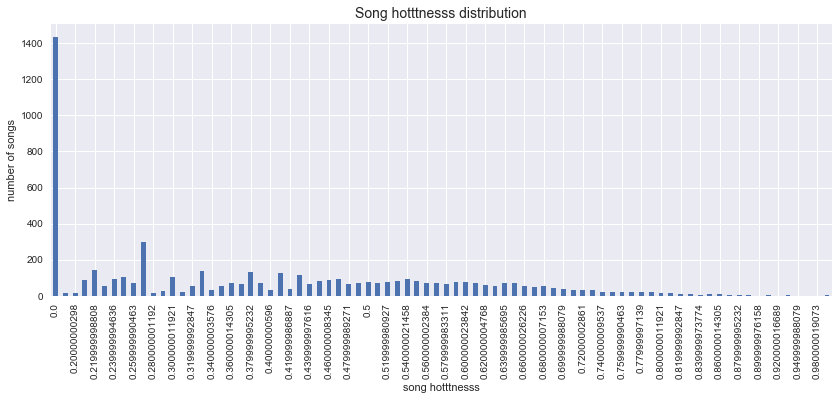

In [22]:
#round the 'song hotttnesss' to the nearest hundredth, in order to limit the number of bins
ax = round(data['song hotttnesss'], 2).value_counts()\
                                                                   .sort_index()\
                                                                   .plot(kind='bar',
                                                                         grid=True,
                                                                         figsize=(14, 5));

ax.set_title('Song hotttnesss distribution', fontsize=14)
ax.set_xlabel('song hotttnesss')
ax.set_ylabel('number of songs');
set_ticks_wtih_step(ax, 2)

In [23]:
data[data['song hotttnesss']==0].count()[0]

1434

From this plot, we see that a really large number of songs have a `song hotttnesss` of 0.
As a result, the bars corresponding to a non-zero `song hotttnesss` tend to be rather squeezed. 
Below, we provide the same barplot, but excluding the 0 values (1434 of them), to see better what happens.

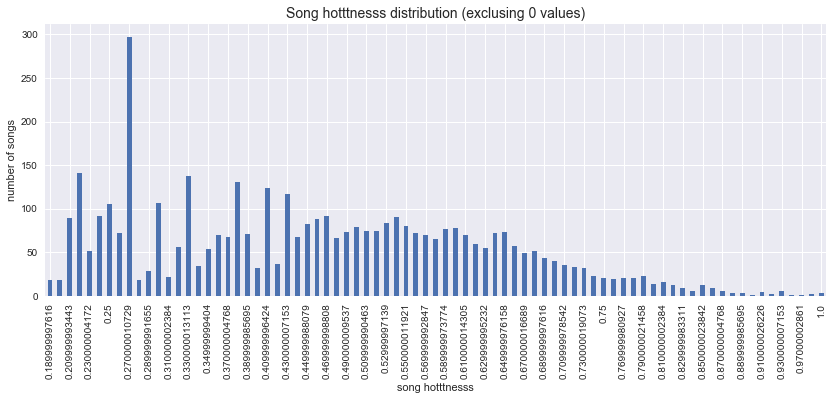

In [24]:
#round the 'song hotttnesss' to the nearest hundredth, in order to limit the number of bins
ax = round(data[data['song hotttnesss'] > 0]['song hotttnesss'], 2).value_counts()\
                                                                   .sort_index()\
                                                                   .plot(kind='bar',
                                                                         grid=True,
                                                                         figsize=(14, 5));

ax.set_title('Song hotttnesss distribution (exclusing 0 values)', fontsize=14)
ax.set_xlabel('song hotttnesss')
ax.set_ylabel('number of songs');
set_ticks_wtih_step(ax, 2)

The distribution of the `song hotttness` does not seem to correspond to a particular known distribution.
Most of the songs have an average to low `song hotttnesss`.
This will still be useful for determining what are the features that could make a song unpopular.

#### Release year

In [705]:
describe(data, 'year', True)

,year
count,10000.000000
mean,934.704600
std,996.650657
min,0.000000
25%,0.000000
50%,0.000000
75%,2000.000000
max,2010.000000


Like for the `song hotttnesss`, we see that the minimum `year` is 0. Here however, 0 actually stands for `undefined`. In our statistics, we will therefore not include those songs for which a certain feature is undefined, as this would bias the distributions.

In [706]:
describe(data, 'year', False)

,year
count,4680.000000
mean,1997.232051
std,11.686691
min,1926.000000
25%,1993.000000
50%,2001.000000
75%,2006.000000
max,2010.000000


Now the earliest `year` is 1926, which indeed appears to  be more realistic. The majority of the songs in the dataset has been released in the last 20 years, although the most recent ones date back to 2010 already. 

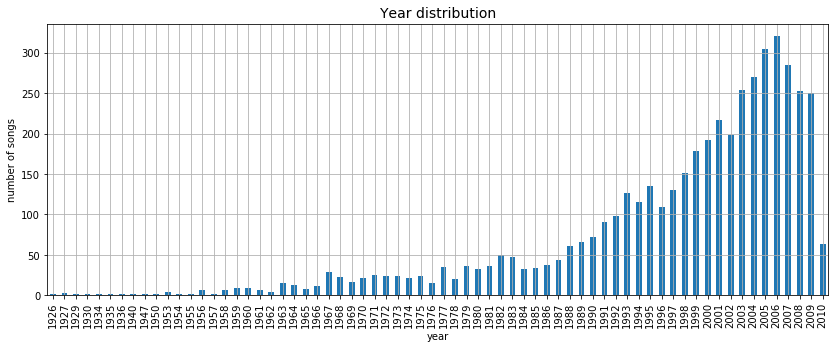

In [707]:
ax = data[data['year'] > 0]['year'].value_counts()\
                                   .sort_index()\
                                   .plot(kind='bar',
                                         grid=True,
                                         figsize=(14, 5));
        
ax.set_title('Year distribution', fontsize=14)
ax.set_xlabel('year')
ax.set_ylabel('number of songs');

Most of the songs we are going to deal with came out in 2000 and later. Hopefully, the ones which were popular in 2011, when the Million Song Dataset was created, remain so to these days. Otherwise, predicting the 2018's best hit might prove more challenging than expected!

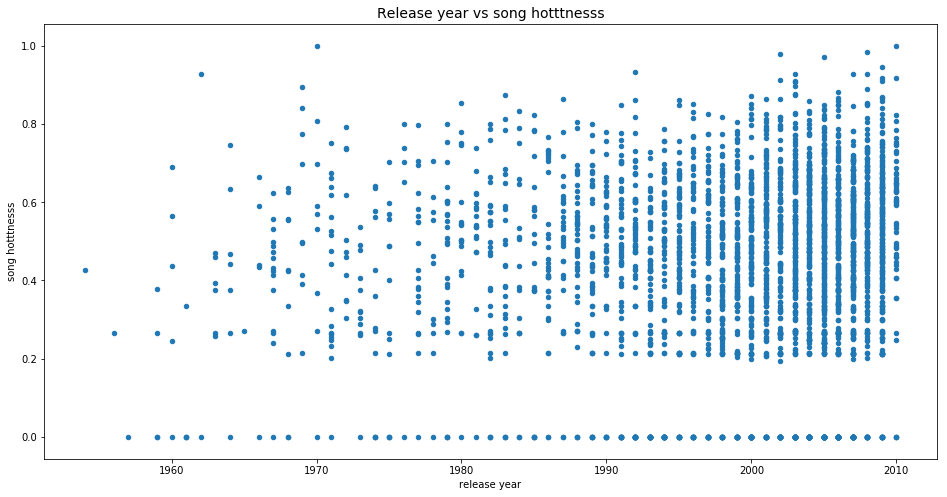

In [708]:
ax = data[(data['year'] != 0) ].plot(kind='scatter', x='year', y='song hotttnesss', figsize=(16,8))
ax.set_title('Release year vs song hotttnesss', fontsize=14)
ax.set_xlabel('release year')
ax.set_ylabel('song hotttnesss');

<div class="alert alert-warning">
Nb: Note the strange gap between 'song hotttness' = 0 and 0.2
<br>After a small investigation, we simply see that over the 26 songs in this range, only 3 have a year not equal to 0.
</div>

In [709]:
data[ (data['song hotttnesss'] > 0) & (data['song hotttnesss'] < 0.2) & (data['year'] != 0)]['song hotttnesss']

70      0.199238
278     0.193858
1009    0.199683
Name: song hotttnesss, dtype: float32

In [713]:
data_valid= data[(data['song hotttnesss'] != 0) & (data['year'] != 0)]
source = ColumnDataSource(data=dict(
    y=data_valid['song hotttnesss'],
    x=data_valid['year'],
    title=data_valid['title'],
    artist=data_valid['artist name'],
    song_hotttnesss=data_valid['song hotttnesss'],
    year=data_valid['year']
))

hover = HoverTool(tooltips=[
    ('Title', '@title'),
    ('Artist', '@artist'),
    ('Song hotttnesss', '@song_hotttnesss'),
    ('Year', '@year')
])

hover_scatter_plot(source, hover, 
                   'Song hotttnesss vs release year', 'release year', 'song hotttnesss',
                    None, None, 'horizontal', 'MSD', 900, 600)

Most songs with the highest `song hotttnesss` are among the most recent ones. 
This may be because they are genuinely more popular, or also because the MSD or the MSD subset sampled more songs from these last years.
*Immigrant Song* from Led Zeppelin appears to be an early hit.

#### Artist hotttnesss

In [326]:
data_a_h = round(data[data['artist hotttnesss'] > 0]['artist hotttnesss'], 2).value_counts().sort_index()

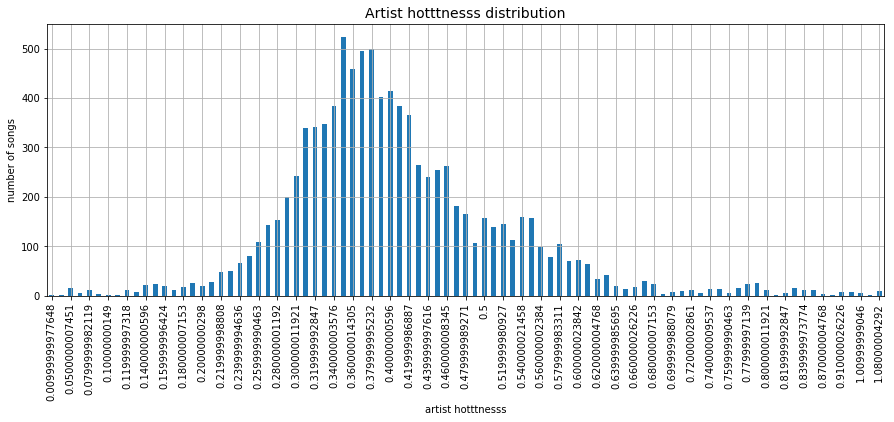

In [328]:
#round the 'song hotttnesss' to the nearest hundredth, in order to limit the number of bins
ax = data_a_h.plot(kind='bar',grid=True,figsize=(15, 5));
ax.set_title('Artist hotttnesss distribution', fontsize=14)
ax.set_xlabel('artist hotttnesss')
ax.set_ylabel('number of songs');

set_ticks_wtih_step(ax, 2)

The distribution of the `artist hotttnesss` appears to be Gaussian-like, except for the fact that it is not really symetric: there are two many values between 0.5 and 0.6 for it to be considered Gaussian.

According to The Echo Nest, these are the artists with the highest `artist hotttnesss` score

In [340]:
threshold = 0.9
data_tmp = data[data['artist hotttnesss'] > threshold].sort_values('artist hotttnesss', ascending=False)[['artist name', 'artist hotttnesss']].drop_duplicates().reset_index(drop=True)
data_tmp

,artist name,artist hotttnesss
0,Kanye West,1.082503
1,Kanye West / Adam Levine,1.082503
2,Kanye West / Consequence / CamRon,1.082503
3,Kanye West / Lupe Fiasco,1.082503
4,Daft Punk,1.021256
5,Black Eyed Peas,1.005942
6,Black Eyed Peas / Les Nubians / Mos Def,1.005942
7,Black Eyed Peas / Terry Dexter,1.005942
8,Taylor Swift,0.922412
9,Coldplay,0.916053


However, we see that many of these "artists" are actually collaborations, and that the `artist hotttnesss` does not change for the lead artist. 
For clarity, we only keep the entries about single artists.

In [341]:
# filter out collaborations
data_tmp = data_tmp[~data_tmp['artist name'].str.contains('/')]
data_tmp

,artist name,artist hotttnesss
0,Kanye West,1.082503
4,Daft Punk,1.021256
5,Black Eyed Peas,1.005942
8,Taylor Swift,0.922412
9,Coldplay,0.916053
10,Rihanna,0.908203


#### Artist hotttnesss vs song hotttnesss

We now want to verify whether an artist with a low/high `artist hotttnesss` value also has a low/high `song hotttnesss` average.
We expect this to be the case, although it would also be interesting to find see which unpopular artist released popular songs.

In [25]:
# group by 'artist name' and take the average of the 'song hotttnesss's
artist_song_hotttnesss_avg = data.groupby('artist name')['artist name', 'song hotttnesss'].mean()
artist_song_hotttnesss_avg.rename(columns = {'song hotttnesss':'song hotttnesss average'}, inplace=True)
artist_song_hotttnesss_avg.reset_index(inplace=True)
artist_song_hotttnesss_avg.head()

,artist name,song hotttnesss average
0,!!!,0.0
1,(hed) p.e.,NaN
2,089 Clique feat. Minnesota Snipe & Skinny Cueball,0.0
3,089 Clique feat. Prophet,0.0
4,1. Futurologischer Congress,0.0


In [26]:
print('Number of rows:', len(artist_song_hotttnesss_avg))

Number of rows: 4408


In [27]:
# keep the 'artist name' and the 'artist hotttnesss'
artist_hotttnesss = data[['artist name', 'artist hotttnesss']]
artist_hotttnesss = artist_hotttnesss.drop_duplicates()
artist_hotttnesss.reset_index(drop=True, inplace=True)
artist_hotttnesss.head()

,artist name,artist hotttnesss
0,Casual,0.401998
1,The Box Tops,0.417500
2,Sonora Santanera,0.343428
3,Adam Ant,0.454231
4,Go,0.401724


In [28]:
print('Number of rows:', len(artist_hotttnesss))

Number of rows: 4566


Oddly, we see that there are more rows in this dataframe than in the previous one, although the number of artist should be the same in both.
We will therefore take the average of the `artist hotttnesss` for artists with multiple `artist hotttnesss` values.

In [29]:
artist_hotttnesss = pd.DataFrame(artist_hotttnesss.groupby('artist name')['artist hotttnesss'].mean())
artist_hotttnesss.reset_index(inplace=True)
artist_hotttnesss.head()

,artist name,artist hotttnesss
0,!!!,0.482131
1,(hed) p.e.,0.324881
2,089 Clique feat. Minnesota Snipe & Skinny Cueball,0.000000
3,089 Clique feat. Prophet,0.000000
4,1. Futurologischer Congress,0.256978


In [30]:
print('Number of rows:', len(artist_hotttnesss))

Number of rows: 4408


The number of rows is now the same in both dataframes. 
The next step consists of merging the two dataframes on the `artist name`.

In [31]:
df = pd.merge(artist_hotttnesss , artist_song_hotttnesss_avg, on='artist name', how='outer')
df.head()

,artist name,artist hotttnesss,song hotttnesss average
0,!!!,0.482131,0.0
1,(hed) p.e.,0.324881,NaN
2,089 Clique feat. Minnesota Snipe & Skinny Cueball,0.000000,0.0
3,089 Clique feat. Prophet,0.000000,0.0
4,1. Futurologischer Congress,0.256978,0.0


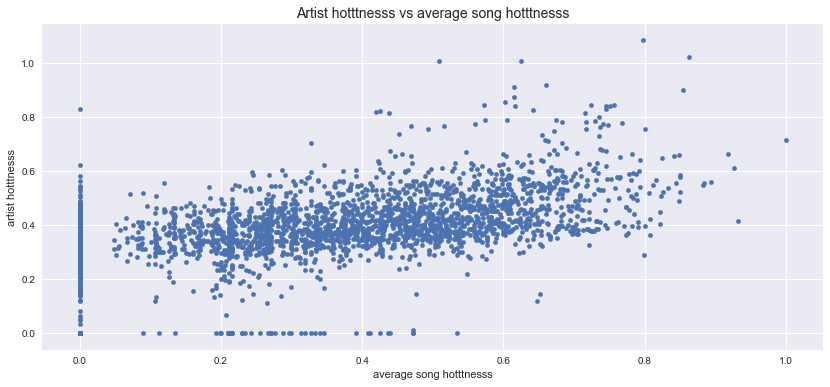

In [32]:
ax = df.plot(kind='scatter', x='song hotttnesss average', y='artist hotttnesss', figsize=(14, 6));
ax.set_title('Artist hotttnesss vs average song hotttnesss', fontsize=14)
ax.set_xlabel('average song hotttnesss')
ax.set_ylabel('artist hotttnesss');

In [35]:
source = ColumnDataSource(data=dict(
    y=df['song hotttnesss average'],
    x=df['artist hotttnesss'],
    artist=df['artist name']
))

hover = HoverTool(tooltips=[
    ('Artist', '@artist')
])

hover_scatter_plot(source, hover, 
                   'average song hotttnesss vs artist hotttnesss', 'average song hotttnesss', 'artist hotttnesss',
                    None, None, 'horizontal', 'MSD', 900, 600)

As expected, there is a visible correlation between the `artist hotttnesss` and the average `song hotttnesss` for a given artist, with the average `song hotttnesss` increasing when the `artist hotttnesss` increases, and vice-versa.

#### Song duration

In [350]:
describe(data, 'duration', False)

,duration
count,10000.000000
mean,238.507278
std,114.137314
min,1.044440
25%,176.032196
50%,223.059143
75%,276.375061
max,1819.767700


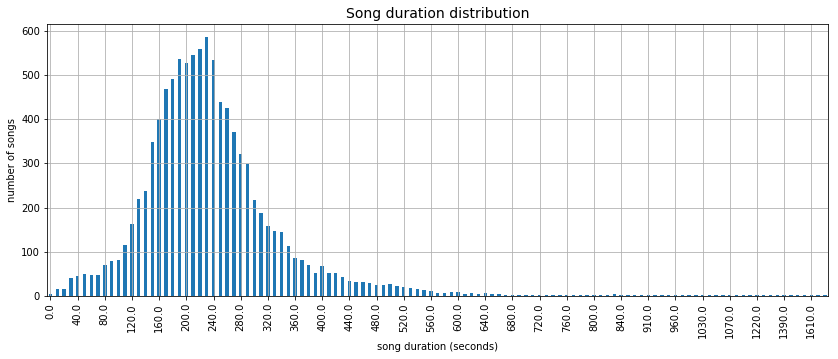

In [351]:
ax = round(data['duration'], -1).value_counts()\
                                .sort_index()\
                                .plot(kind='bar', 
                                      grid=True,
                                      figsize=(14, 5));
        
ax.set_title('Song duration distribution', fontsize=14)
ax.set_xlabel('song duration (seconds)')
ax.set_ylabel('number of songs')
set_ticks_wtih_step(ax, 4)

The `song duration` may be following a lognormal distribution.
The data is asymetric, with most outliers lying to the right, and some to the left: the most common distributions for this type of data are the lognormal, the Gamma, the Weibull distributions.
Since many natural phenomenons related to some *length* have been observed to follow a lognormal ditribution, then most likely so does the `song duration`.

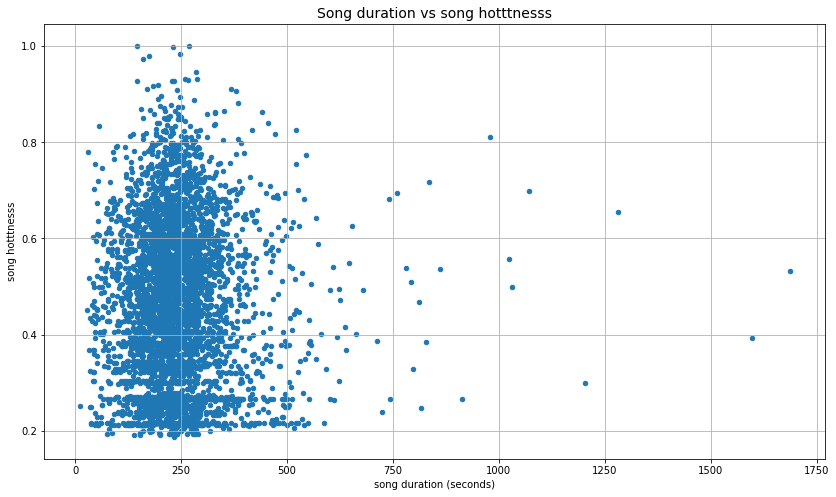

In [685]:
ax = data[data['song hotttnesss'] != 0].plot(kind='scatter', x='duration', y='song hotttnesss', figsize=(14,8), grid=True);
ax.set_title('Song duration vs song hotttnesss', fontsize=14)
ax.set_xlabel('song duration (seconds)')
ax.set_ylabel('song hotttnesss');

In [136]:
data_valid= data[data['song hotttnesss'] != 0]
source = ColumnDataSource(data=dict(
    y=data_valid['song hotttnesss'],
    x=data_valid['duration'],
    title=data_valid['title'],
    artist=data_valid['artist name'],
    song_hotttnesss=data_valid['song hotttnesss'],
    duration=data_valid['duration']
))

hover = HoverTool(tooltips=[
    ('Title', '@title'),
    ('Artist', '@artist'),
    ('Song hotttnesss', '@song_hotttnesss'),
    ('Duration', '@duration')
])

hover_scatter_plot(source, hover, 
                   'Song hotttnesss vs song duration', 'song duration (seconds)', 'song hotttnesss',
                    None, None, 'horizontal', 'MSD', 800, 400)

There does not seem to be any particular correlation between the `song hotttnesss` and the `song duration`.
We observe that the most popular songs are neither particularly long or particularly short, but have a `song duration` around the mean.

#### Artist terms

The `artist terms` feature for each song roughly corresponds to the music styles associated to this artist, according to The Echo Nest.
Additionally, there are the `artist terms weight` and the `artist terms freq`, which represent the weight respectively the frequency of each artist term (both between 0.0 and 1.0).

In [170]:
top_list = data['artist terms']
artist_terms_all = [item for sublist in top_list for item in sublist]
artist_terms_distinct = set(artist_terms_all)

print('Total number of artist terms:', len(artist_terms_all))
print('Number of distinct artist terms:', len(artist_terms_distinct))

Total number of artist terms: 266611
Number of distinct artist terms: 3502


In [70]:
serie = pd.Series(artist_terms_all).value_counts()

In [71]:
serie.sort_values(ascending=False).head(10)

rock                6493
pop                 5476
electronic          4453
jazz                3596
united states       3084
hip hop             2926
alternative rock    2753
folk                2598
alternative         2586
soul                2491
dtype: int64

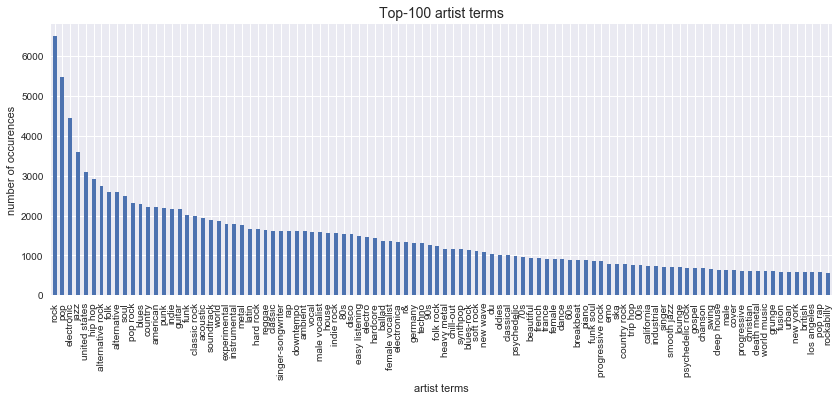

In [72]:
top = 100
ax = serie.sort_values(ascending=False).head(top)\
                                       .plot(kind='bar',
                                             grid=True,
                                             figsize=(14, 5));
    
ax.set_title('Top-' + str(top) + ' artist terms', fontsize=14)
ax.set_xlabel('artist terms')
ax.set_ylabel('number of occurences');

It would seem the songs in the MSD subset (and most likely the MSD dataset in general) are heavily rock and pop oriented.

In [344]:
threshold = 0.9
top_songs = data[data['song hotttnesss'] >= threshold]

In [345]:
top_artist_terms = flatmap(top_songs['artist terms'])
top_artist_terms_weight = flatmap(top_songs['artist terms weight'])

In [346]:
list_tuples = list(zip(top_artist_terms, top_artist_terms_weight))

In [347]:
from collections import defaultdict

groups = defaultdict(list)

#group by term
for item in list_tuples:
    groups[item[0]].append(item[1])

#compute the mean
for item in groups.items():
    groups[item[0]] = (np.mean(item[1]), np.std(item[1]))
                       

In [348]:
top_artist_terms_sorted = sorted(groups.items(), key=lambda value: value[1][0], reverse=True)

In [349]:
df = pd.DataFrame()
df['artist terms'] = [item[0] for item in top_artist_terms_sorted]
df['mean artist terms weight'] = [item[1][0] for item in top_artist_terms_sorted]
df['std artist terms weight'] = [item[1][1] for item in top_artist_terms_sorted]
df.head(20)

,artist terms,mean artist terms weight,std artist terms weight
0,teen pop,1.000000,0.000000
1,rap rock,1.000000,0.000000
2,experimental rock,1.000000,0.000000
3,dirty south rap,1.000000,0.000000
4,jazz rap,1.000000,0.000000
5,piano rock,0.999826,0.000000
6,post-grunge,0.999634,0.000000
7,pop punk,0.985320,0.014680
8,indie pop,0.983775,0.000000
9,soul jazz,0.973970,0.000000


<function matplotlib.pyplot.tight_layout>

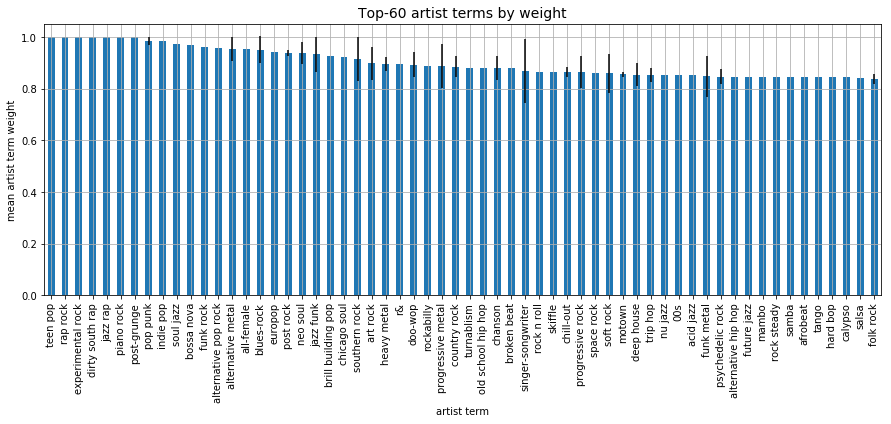

In [687]:
top = 60
error = df.head(top)['std artist terms weight']
ax = df.head(top)['mean artist terms weight'].plot(kind='bar', yerr=error, grid=True, figsize=(15, 5));

ax.set_title('Top-' + str(top) + ' artist terms by weight', fontsize=14)
ax.set_xlabel('artist term')
ax.set_ylabel('mean artist term weight')
ax.set_xticklabels(df['artist terms'])
plt.tight_layout;

In [242]:
#consider regrouping artist terms into less groups
#"rap rock", "funk rock", funk rap", "jazz funk", "jazz rap", "jazz rock" ...........

For now, we did not analyse the `artist mbtags`, since compared to the `artist terms`, many songs were at that time not evaluated.

#### Beats

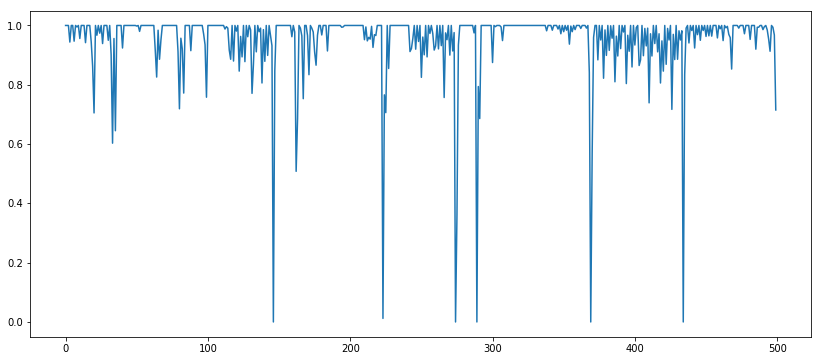

In [688]:
idx = 9
plt.figure(figsize=(14, 6))
serie = data['beats confidence'][idx]
plt.plot(np.arange(0,len(serie)), serie);

#### Geography
To be explored...


#### Key
There is 24 of them. Twelve are Majors and the all have what we call a minor relative. The major keys are in order :
$$ C - G - D - A - E - B - F\# - C\# - A\flat - E\flat - B\flat - F $$
as we can see in this picture :

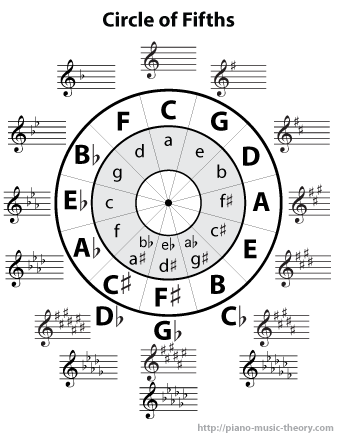

In [692]:
from IPython.display import Image
Image("img/fifths.png")

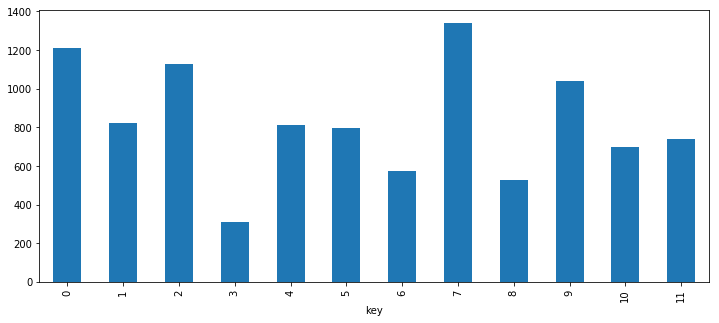

In [693]:
data_key = data.groupby('key')['key'].count()
data_key.index = data_key.index.astype(int)
data_key.sort_index().plot(kind='bar',figsize=(12,5))

We checked (manually...with the help of "findsongtempo.com") these song to get the matching between the key in data and the real key :

In [695]:
dd = pd.DataFrame()
for key in range(12) :
     dd = dd.append((data[(data['key'] == str(key)) 
      & (data['artist hotttnesss'] > 0.6)
      & (data['key confidence'] > 0.84)][['artist name', 'title','key confidence', 'key']]).head(1))
dd

,artist name,title,key confidence,key
660,Radiohead,Subterranean Homesick Alien,0.847,0
1059,Lloyd Banks,South Side Story,1.000,1
1427,Jack Johnson,You And Your Heart,1.000,2
247,U2,Kite Live from Sydney,0.878,3
507,Shakira,Pienso En Ti,0.970,4
2559,Eminem,Beautiful,1.000,5
9226,Bon Jovi / Ray Davies,Celluloid Heroes,0.896,6
108,Martina McBride,I Cant Stop Loving You,0.960,7
3336,Enrique Iglesias,Do You Know? (The Ping Pong Song),0.918,8
3097,Enrique Iglesias,Si Juras Regresar,0.930,9


Results by exploration :

| Key number | Key |
|:-----:|-----|-|
|0|C| |
|1|C$\sharp$|
|2|D| 
|3|E$\flat$| 
|4|E| 
|5|F| 
|6|?| 
|7|G| 
|8|A$\flat$| 
|9|A| 
|10|B$\flat$| 
|11| ?| 

We found 2 inccorect/unprecise results. But we can see that the key isn't the index in the fifths cycle, but simply the 12 half tone in the music scale.

In [697]:
key_to_explore = 5
(data[(data['key'] == str(key_to_explore)) 
      & (data['artist hotttnesss'] > 0.6)
      & (data['key confidence'] > 0.8)][['artist name', 'title','key confidence']]).head(1)

,artist name,title,key confidence
2559,Eminem,Beautiful,1.0


By further analysis, it is important that we can select the key of our song. 

#### Non-evaluated features

Unfortunately, some features such as `energy` or `danceability` happen to not have been evaluated for any of the songs in the Million Song Dataset subset, so that we were not able to use them in this first analysis.

The whole Million Song Dataset most likely contains a few songs were these features have been evaluated though.

In [240]:
describe(data, 'energy', True)

,energy
count,10000.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [241]:
describe(data, 'danceability', True)

,danceability
count,10000.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


## Applying the analysis to the Million Song Dataset *(milestone 3)*

Once we move to the whole Million Song Dataset, we will obviously not be saving 280 GB to .csv files.

What we will do instead is collect the data from the cluster using the `GetData.py` Python script.
In this script, we will be dropping the features we are not interested in, which will reduce the size of the data per song significantly (e.g. `segments timbre`, `segment pitches`, ..., if we do not find a use for these feature in our analysis).

### Retrieving the data using a json

In [716]:
import json
strjson = open('data.json').read()
strjson = '{"columns":["year", "artist latitude", "artist longitude", "artist hotttnesss", "artist id", "song id", "title", "artist terms", "artist terms weight", "song hotttnesss", "danceability", "duration", "energy"],"data":['+strjson[:-2]+']}' 
json = json.loads(strjson)



In [717]:
data = pd.read_json(strjson,orient='split')

In [718]:
data.head()

,year,artist latitude,artist longitude,artist hotttnesss,artist id,song id,title,artist terms,artist terms weight,song hotttnesss,danceability,duration,energy
0,1996,40.73197,-74.17418,0.620222,AR30R5E1187B9AD78A,SODYOQM12A58A7A0E3,Somebody Bigger Than You And I,"[dance pop, quiet storm, r&b, ballad, soft roc...","[1.0, 0.9425660227595801, 0.8860338059041051, ...",0.400040,0,281.70404,0
1,2002,41.08419,-81.51406,0.741724,ARS8GNX1187B9B5141,SONYEUZ12AB01885E8,Brooklyn Bound,"[blues-rock, punk blues, blues, alternative ro...","[1.0, 1.0, 0.9131619499536121, 0.8480219466715...",0.742843,0,189.96200,0
2,2010,51.50632,-0.12714,0.458829,ARKFJI71187FB55484,SODHKYQ12AC4685299,October,"[folktronica, indie pop, indie, electronica, f...","[1.0, 0.830558137395466, 0.8066174871292141, 0...",0.758061,0,229.69424,0
3,2004,41.88415,-87.63241,0.500720,ARCVU3T1187FB4D79D,SONRQOA12AB0186E36,If U Ever,"[neo soul, soul jazz, downtempo, nu-soul, smoo...","[1.0, 0.9819961205739891, 0.9012790060726951, ...",0.494470,0,255.21587,0
4,2005,63.13626,18.81030,0.415241,AR20YYS1187B9B9BB2,SOMKUGB12A8C140816,Utnyttjad Och Konsumerad,"[twee pop, indie pop, pop, sweden, scandinavia...","[1.0, 0.915353755243233, 0.846228290787536, 0....",0.407975,0,147.12118,0


In [721]:
strjson[:1000]

'{"columns":["year", "artist latitude", "artist longitude", "artist hotttnesss", "artist id", "song id", "title", "artist terms", "artist terms weight", "song hotttnesss", "danceability", "duration", "energy"],"data":[[1996, 40.731969999999997, -74.174180000000007, 0.62022161333903358, "AR30R5E1187B9AD78A", "SODYOQM12A58A7A0E3", "Somebody Bigger Than You And I", ["dance pop", "quiet storm", "r&b", "ballad", "soft rock", "easy listening", "urban", "female vocalist", "soundtrack", "pop", "disco", "smooth jazz", "adult contemporary", "oldies", "emo", "soul music", "neo soul", "hip hop", "classic rock", "80s", "soul", "singer-songwriter", "blues", "rock", "funk", "new wave", "club", "jazz", "pop rock", "90s", "american", "female", "rap", "hard rock", "00s", "alternative", "techno", "alternative rock", "folk", "indie"], [1.0, 0.9425660227595807, 0.8860338059041051, 0.883440796120808, 0.872197625338997, 0.8531063110468546, 0.8246736474720542, 0.8177924181767203, 0.815890562856696, 0.81089106

### To be done ...

After having explored the Million Song Dataset subset, we decided to drop a number a features, in particular the time series describing the audio of the song. 
There are two main reasons for this:
* First, due to the time constraint, we decided not to analyse these features
* Second, this significantly reduces the size of the data, thus making it easier to handle, as it can be kept locally (we go from 280 GB to XXX MB)

The features we kept are the followings:
* Song-related features
  * `song id`
  * `track id`
  * `title`
  * `year`
  * `duration`
  * `song hotttnesss`
  * `danceability`
  * `energy`
* Artist-related features
  * `artist id`
  * `artist name`
  * `artist terms`
  * `artist terms weight`
  * `artist latitude`
  * `artist longitude`
  * `artist location`
  * `artist hotttnesss`
  
whereas the features we dropeed are:
  * `analysis sample rate`
  * `artist 7digitalid`
  * `artist familiarity`
  * `artist mbid`
  * `artist mbtags`
  * `artist mbtags count`
  * `artist playmeid`
  * `artist terms freq`
  * `audio md5`
  * `bars confidence`
  * `bars start`
  * `beats confidence`
  * `beats start`
  * `end of fade in`
  * `index` 
  * `key`
  * `key confidence`
  * `loudness`
  * `mode`
  * `mode confidence`
  * `num songs`
  * `release`
  * `release 7digitalid`
  * `sections confidence`
  * `sections start`
  * `segments confidence`
  * `segments start`
  * `segments loudness max`
  * `segments loudness max time`
  * `segments loudness start`
  * `segments pitches`
  * `segments start`
  * `segments timbre`
  * `similar artists`
  * `start of fade out`
  * `tatums confidence`
  * `tatums start`
  * `tempo`
  * `time signature`
  * `time signature confidence`
  * `track 7digitalid`

In [6]:
path_msd = './data/msd/'

In [7]:
data_msd = pd.read_json(path_msd + 'msd_filtered_part1.json', orient='split')
data_msd.head(1)

,year,artist latitude,artist longitude,artist hotttnesss,artist id,song id,title,artist terms,artist terms weight,song hotttnesss,danceability,duration,energy,artist name,track id,artist location
0,1984,NaN,NaN,0.332276,AR8ZCNI1187B9A069B,SOIAZJW12AB01853F1,Pink World,"[new wave, progressive rock, space rock, eurod...","[1.0, 0.9869619197460081, 0.983064531867962, 0...",0.265861,0,269.81832,0,Planet P Project,TRAAARJ128F9320760,


In [8]:
data = data_msd.copy()
print('Number of songs:', len(data))

Number of songs: 159430


In [10]:
#single values
data['title'] = clean_string_column(data['title'])
data['artist name'] = clean_string_column(data['artist name'])
data['artist id'] = clean_string_column(data['artist id'])
data['artist location'] = clean_string_column(data['artist location'])
data['track id'] = clean_string_column(data['track id'])

#arrays
data['artist terms'] = clean_string_column(data['artist terms'])

### Geographic analysis

This section serves two purposes. The first one is to give a geographic overview of the origin of the songs in the Million Song Dataset. The second one is to determine whether there is a relationship between the geographic origin of a song, and its `song hotttnesss`.

To do this, we will use the corresponding `artist latitude` and the `artist longitude` as the "geographic coordinates" of a song.
However, we are not interested in the exact geographic coordinates, but only the country of origin of the song. 
We will therefore perform a reverse geolocalization query on each coordinate in order to recover the corresponding country.



In the dataset, songs also have a `artist location` field which can be used to assign it a geographic location.


In [200]:
path_geolocation = './data/geolocation/'

In a first step, we collect all valid coordinates from the dataset (i.e. all coordinates which are not NaN).
Songs with the same artist are likely to have the same `artist latitude` and `artist longitude` as well, but since we do not want to query those coordinates twice, we also drop all duplicates coordinates.

Additionally, we save all coordinates to a file.

In [1620]:
# filter out NaN coordinates and drop duplicates
valid_coordinates = data[['artist latitude', 'artist longitude']].dropna().drop_duplicates()

# save all coordinates in a file
valid_coordinates.to_csv(path_geolocation+'coordinates_msd.txt', sep=',', encoding='utf-8', header=None, index=False)

# make a list of coordinates
valid_coordinates =  list(zip(valid_coordinates['artist latitude'], valid_coordinates['artist longitude']))

print('Number of (distinct) valid coordinates (i.e. not NaN):', len(list(set(valid_coordinates))))

Number of (distinct) valid coordinates (i.e. not NaN): 1875


Unfortunately, the geographic coordinates are defined for only XXX songs, that is for roughly XXX% of the songs in the dataset.

We do not know why certain songs do not have geographic coordinates assigned to them: it may be because the team which collected the data simply omitted them for some songs (unknown, uncertain, not relevant, ...), because they are generally unknown, or maybe because of some other reason.

However, this means that we cannot be sure that the sample of songs with geographic coordinates is actually representative for the whole dataset. 
Therefore, it may be the case that the observations we are making do not apply for the whole dataset.

In [1615]:
print('Number of songs with valid coordinates:', len(data[~data['artist longitude'].isnull()]))

Number of songs with valid coordinates: 58277


In [1621]:
from itertools import islice

# returns a list of coordinates from the file with the given <filename>
# estarts from line number <start> (included) and ends at line number <end> (excluded)
def get_next_coordinates(filename, start, end):
    coordinates_list = []
    with open(path_geolocation+filename) as f:
        for line in islice(f, start, end):
            line = line.rstrip('\n')
            coordinates = (float(line.split(',')[0]), float(line.split(',')[1]))
            coordinates_list.append(coordinates)
    return coordinates_list

In [1617]:
# returns a list of coordinates from the file with the given <filename>
# eventually skips the lines with the line numbers given in <skiplines>
def get_coordinates(filename, skiplines):
    coordinates_list = []
    i = 1
    with open(path_geolocation+filename) as f:
        for line in f:
            if i not in skiplines:
                line = line.rstrip('\n')
                coordinates = (float(line.split(',')[0]), float(line.split(',')[1]))
                coordinates_list.append(coordinates)
            i+=1
    return coordinates_list

In [1628]:
from pygeocoder import Geocoder
from pygeolib import GeocoderError

# performs a reverse geolocalization query on the given list of coordinates
# writes the result (latitude, longitude, coutry, city) in the file with the given <filename>
def query_reverse_geolocation(coordinates, filename):
    done = False
    
    while(not done):
        try:
            results = Geocoder.reverse_geocode(coordinates[0], coordinates[1])
            print(results.coordinates, ' ', results.country, ' ', results.city)
            
            # precision problem between queried coordinates and returned coordinates (<results.coordinates>)
            # --> do not store <results.coordinates>, but the queries coordinates
            country = results.country
            city = results.city

            with open(path_geolocation+filename, 'ab') as myfile:
                value = str(coordinates[0]) + '\t' + str(coordinates[1]) + '\t' + str(country) + '\t' + str(city) + '\n'
                myfile.write(value.encode('utf-8'))

            done = True
        except GeocoderError:
            print('Error OVER_QUERY_LIMIT' + ' -- try again later')
            time.sleep(4) # delay in seconds

We now reverse-query the country and the city of each pair of coordinates in the dataset, and save the result to file.

*note: skip this code cell if the 'coordinates_map.txt' file has already been built
(this code needs not to be run again if all coordinates have already been queried and the file has been built)*

In [1635]:
#note: some incorrect coordinates, so skip these (line number in .csv file)
#skiplines = [411, 569]
skiplines = [197, 779]
start = 1000
end = 1875
filename = 'coordinates_msd.txt' # read from this file
filename_to = 'coordinates_map_msd.txt' # write to this file
coordinates_list = get_next_coordinates(filename, start, end)

i = start
for coordinates in coordinates_list:
    print('Querying coordinates #', i, '...')
    query_reverse_geolocation(coordinates,filename_to)
    i += 1

Querying coordinates # 1000 ...
Error OVER_QUERY_LIMIT -- try again later
(38.5348037, -82.6843817)   United States   Ironton
Querying coordinates # 1001 ...
(33.3530758, -90.5903051)   United States   Inverness
Querying coordinates # 1002 ...
(33.7740202, -84.296627)   United States   Decatur
Querying coordinates # 1003 ...
(47.4211111, -68.1958372)   Canada   None
Querying coordinates # 1004 ...
(39.5251674, -87.11869899999999)   United States   Brazil
Querying coordinates # 1005 ...
Error OVER_QUERY_LIMIT -- try again later
(35.00441, -91.2516564)   United States   Cotton Plant
Querying coordinates # 1006 ...
(40.8793028, -73.3114581)   United States   East Northport
Querying coordinates # 1007 ...
(42.3076017, -71.2795123)   United States   Wellesley
Querying coordinates # 1008 ...
(19.4091039, -99.15028389999999)   Mexico   Ciudad de México
Querying coordinates # 1009 ...
(32.9670925, -93.1419372)   United States   Haynesville
Querying coordinates # 1010 ...
(31.327518, -89.290616

(-32.0530159, 115.7483937)   Australia   Fremantle
Querying coordinates # 1091 ...
(31.2457378, -90.4540916)   United States   McComb
Querying coordinates # 1092 ...
(35.5645473, -89.6460702)   United States   Covington
Querying coordinates # 1093 ...
(39.6187178, -105.2332448)   United States   Indian Hills
Querying coordinates # 1094 ...
Error OVER_QUERY_LIMIT -- try again later
(41.46785630000001, -82.1786474)   United States   Lorain
Querying coordinates # 1095 ...
(44.1505338, -78.4481114)   Canada   Millbrook
Querying coordinates # 1096 ...
(43.5883711, -79.6444484)   Canada   Mississauga
Querying coordinates # 1097 ...
(51.2218849, 4.3976944)   Belgium   Antwerpen
Querying coordinates # 1098 ...
(36.690871, -6.1347346)   Spain   Jerez de la Frontera
Querying coordinates # 1099 ...
(51.5820174, -0.0746673)   United Kingdom   London
Querying coordinates # 1100 ...
(50.7321289, 7.101563499999999)   Germany   Bonn
Querying coordinates # 1101 ...
(40.0084125, -75.1529017)   United St

(59.956992, 11.0480891)   Norway   Lillestrøm
Querying coordinates # 1182 ...
(43.5971936, -84.7681518)   United States   Mount Pleasant
Querying coordinates # 1183 ...
(51.1165218, -0.1870314)   United Kingdom   Crawley
Querying coordinates # 1184 ...
(49.1943572, 16.604836)   Czechia   Brno
Querying coordinates # 1185 ...
(50.8499583, 5.6882075)   Netherlands   Maastricht
Querying coordinates # 1186 ...
(46.66952389999999, -110.0491125)   United States   Judith Gap
Querying coordinates # 1187 ...
Error OVER_QUERY_LIMIT -- try again later
(51.4461988, 0.2255434)   United Kingdom   Dartford
Querying coordinates # 1188 ...
(44.1326051, 10.0161655)   Italy   Fosdinovo
Querying coordinates # 1189 ...
(34.1066722, -117.80384)   United States   San Dimas
Querying coordinates # 1190 ...
(36.7308917, -76.589246)   United States   Suffolk
Querying coordinates # 1191 ...
(32.615185, -93.2859945)   United States   Minden
Querying coordinates # 1192 ...
(33.52735150000001, -90.2773831)   United S

(36.4479409, 127.8499398)   South Korea   Boeun-gun
Querying coordinates # 1277 ...
(35.7978434, -95.24983309999999)   United States   Fort Gibson
Querying coordinates # 1278 ...
(-31.9316262, 115.8418533)   Australia   Leederville
Querying coordinates # 1279 ...
(40.7413524, -73.7120411)   United States   None
Querying coordinates # 1280 ...
(41.1136579, -73.4081245)   United States   Norwalk
Querying coordinates # 1281 ...
(51.4509208, 0.0509064)   United Kingdom   London
Querying coordinates # 1282 ...
(30.8344514, -83.2816333)   United States   Valdosta
Querying coordinates # 1283 ...
(35.220369, -97.44672399999999)   United States   Norman
Querying coordinates # 1284 ...
(46.8756668, -96.7817457)   United States   Fargo
Querying coordinates # 1285 ...
(40.436453, -74.20427769999999)   United States   Keyport
Querying coordinates # 1286 ...
Error OVER_QUERY_LIMIT -- try again later
Error OVER_QUERY_LIMIT -- try again later
(-23.6361, -46.7117435)   Brazil   São Paulo
Querying coord

(46.8502105, 9.531179)   Switzerland   Chur
Querying coordinates # 1365 ...
(39.2687228, -76.7994425)   United States   Ellicott City
Querying coordinates # 1366 ...
(34.5102514, -89.94085419999999)   United States   Como
Querying coordinates # 1367 ...
(49.88681, -119.496616)   Canada   Kelowna
Querying coordinates # 1368 ...
(42.9812477, -78.5850191)   United States   Clarence
Querying coordinates # 1369 ...
(52.1290348, 5.9059854)   Netherlands   Hoenderloo
Querying coordinates # 1370 ...
(30.2354583, -92.26831609999999)   United States   Rayne
Querying coordinates # 1371 ...
(22.0772434, -159.317295)   United States   Kapaa
Querying coordinates # 1372 ...
Error OVER_QUERY_LIMIT -- try again later
(40.3605058, -74.6635536)   United States   Princeton
Querying coordinates # 1373 ...
(33.404182, -90.8992169)   United States   Leland
Querying coordinates # 1374 ...
(32.3311203, -90.6053589)   United States   Edwards
Querying coordinates # 1375 ...
(9.353729099999999, 2.3869595)   Benin

(11.4133393, -7.4878784)   Mali   Bougouni
Querying coordinates # 1456 ...
(-36.1689578, 175.4359747)   New Zealand   Great Barrier Island
Querying coordinates # 1457 ...
(64.2756951, -136.2455874)   Canada   None
Querying coordinates # 1458 ...
(32.675705, -83.2261693)   United States   Danville
Querying coordinates # 1459 ...
Error OVER_QUERY_LIMIT -- try again later
(19.0588685, -70.1522191)   Dominican Republic   Cotuí
Querying coordinates # 1460 ...
(34.197771, -101.697776)   United States   Plainview
Querying coordinates # 1461 ...
(49.09963, 2.5159694)   France   Fosses
Querying coordinates # 1462 ...
(53.56915189999999, -1.7935185)   United Kingdom   Holmfirth
Querying coordinates # 1463 ...
(38.8125035, -92.2255989)   United States   Ashland
Querying coordinates # 1464 ...
(52.0917316, -1.9401454)   United Kingdom   Evesham
Querying coordinates # 1465 ...
(51.895266, -0.4278703)   United Kingdom   Luton
Querying coordinates # 1466 ...
Error OVER_QUERY_LIMIT -- try again later


(-33.0429907, -71.3758331)   Chile   Villa Alemana
Querying coordinates # 1545 ...
(48.2464072, 8.372184899999999)   Germany   Schiltach
Querying coordinates # 1546 ...
(38.6156998, -76.90245949999999)   United States   Saint Charles
Querying coordinates # 1547 ...
(41.03295749999999, 28.5441763)   Turkey   None
Querying coordinates # 1548 ...
(45.491774, -114.1299559)   United States   Gibbonsville
Querying coordinates # 1549 ...
(52.478764, -116.072091)   Canada   Nordegg
Querying coordinates # 1550 ...
(32.3502499, -97.3878215)   United States   Cleburne
Querying coordinates # 1551 ...
(40.3283357, -75.10237029999999)   United States   Doylestown
Querying coordinates # 1552 ...
(42.6457626, -71.312963)   United States   Lowell
Querying coordinates # 1553 ...
Error OVER_QUERY_LIMIT -- try again later
(41.3744595, -74.69156339999999)   United States   Port Jervis
Querying coordinates # 1554 ...
(51.4953154, -0.2101552)   United Kingdom   London
Querying coordinates # 1555 ...
(-37.852

(31.8340605, -83.7396242)   United States   Arabi
Querying coordinates # 1635 ...
(46.50108609999999, -66.4143287)   Canada   Porter Cove
Querying coordinates # 1636 ...
Error OVER_QUERY_LIMIT -- try again later
(34.1942265, -118.3916038)   United States   Los Angeles
Querying coordinates # 1637 ...
(28.6433304, -81.2325544)   United States   Oviedo
Querying coordinates # 1638 ...
(33.6868641, -117.8253595)   United States   Irvine
Querying coordinates # 1639 ...
(52.8245854, -2.0302363)   United Kingdom   None
Querying coordinates # 1640 ...
(51.59700549999999, -0.3354347)   United Kingdom   Harrow
Querying coordinates # 1641 ...
(38.3207211, -75.6106607)   United States   Fruitland
Querying coordinates # 1642 ...
(36.5977666, -121.8973595)   United States   Monterey
Querying coordinates # 1643 ...
(54.6365924, -6.812982799999999)   United Kingdom   None
Querying coordinates # 1644 ...
(36.3440438, -85.2906471)   United States   Livingston
Querying coordinates # 1645 ...
Error OVER_QU

(50.5261499, -3.6070657)   United Kingdom   Newton Abbot
Querying coordinates # 1727 ...
Error OVER_QUERY_LIMIT -- try again later
(37.4806276, -93.4275491)   United States   Morrisville
Querying coordinates # 1728 ...
(35.2795886, -84.761955)   United States   Charleston
Querying coordinates # 1729 ...
(51.4425349, 3.5727419)   Netherlands   Vlissingen
Querying coordinates # 1730 ...
(18.3216175, -77.262934)   Jamaica   None
Querying coordinates # 1731 ...
(40.71572800000001, -73.84184)   United States   None
Querying coordinates # 1732 ...
(35.7479191, -95.369188)   United States   Muskogee
Querying coordinates # 1733 ...
(35.0373095, -90.06138419999999)   United States   Memphis
Querying coordinates # 1734 ...
(33.9859773, -88.48932289999999)   United States   Amory
Querying coordinates # 1735 ...
(35.6605591, -91.9204226)   United States   Drasco
Querying coordinates # 1736 ...
(40.2978729, -111.6960402)   United States   Orem
Querying coordinates # 1737 ...
(45.6790708, -111.03317

(27.6955248, -105.1727346)   Mexico   Ciudad Camargo
Querying coordinates # 1820 ...
(38.4809904, -82.64332619999999)   United States   Ashland
Querying coordinates # 1821 ...
(43.7426401, -81.7074351)   Canada   Goderich
Querying coordinates # 1822 ...
(39.1446924, -89.10868909999999)   United States   Ramsey
Querying coordinates # 1823 ...
Error OVER_QUERY_LIMIT -- try again later
(40.37607999999999, -74.0037569)   United States   Rumson
Querying coordinates # 1824 ...
(44.05552369999999, -64.68845449999999)   Canada   Brooklyn
Querying coordinates # 1825 ...
(11.2936767, -60.5328682)   Trinidad and Tobago   None
Querying coordinates # 1826 ...
(49.87236, 8.6502)   Germany   Darmstadt
Querying coordinates # 1827 ...
Error OVER_QUERY_LIMIT -- try again later
(42.5017074, 12.8850763)   Italy   Poggio Bustone
Querying coordinates # 1828 ...
(36.3604084, 6.608224)   Algeria   Constantine
Querying coordinates # 1829 ...
(20.4674074, -102.0562926)   Mexico   None
Querying coordinates # 183

When all coordinates have been reverse-queried and the result saved to file, it is straightforward to load the content of the file into a dataframe.

In [201]:
filename = 'coordinates_map_msd.txt'
df_coordinates = pd.read_csv(path_geolocation+filename, sep='\t', header=None)
df_coordinates.columns = ['latitude', 'longitude', 'country', 'city']
#df_coordinates['latitude'] = df_coordinates['latitude'].astype(np.float32)
#df_coordinates['longitude'] = df_coordinates['longitude'].astype(np.float32)
df_coordinates.head()

,latitude,longitude,country,city
0,41.88415,-87.63241,United States,Chicago
1,37.77916,-122.42005,United States,San Francisco
2,45.51179,-122.67563,United States,Portland
3,51.50632,-0.12714,United Kingdom,London
4,37.54703,-122.31483,United States,San Mateo


In [1637]:
dict_coordinates = dict(zip([tuple(l) for l in df_coordinates[['latitude', 'longitude']].values.tolist()], 
                            [tuple(l) for l in df_coordinates[['country', 'city']].values.tolist()]))

We can now map the `artist latitude` and `artist longitude` in the original dataframe to the corresponding country, by merging both dataframes on the latitude and longitude pairs.

In [1638]:
# method 1
data_tmp = data[['artist latitude', 'artist longitude', 'song hotttnesss']].dropna()
data_tmp['country'] = data_tmp.apply(lambda x: dict_coordinates[(x['artist latitude'], x['artist longitude'])] if (x['artist latitude'], x['artist longitude']) in dict_coordinates else '', axis=1)
len(data_tmp[data_tmp['country'] != ''])

0

In [202]:
# method 2
data_tmp = data[['artist latitude', 'artist longitude', 'song hotttnesss']].dropna()

data_tmp = pd.merge(data_tmp, df_coordinates, how='inner',
                    left_on=['artist latitude', 'artist longitude'],
                    right_on=['latitude', 'longitude'])

data_tmp = data_tmp.drop(['artist longitude', 'artist latitude'], axis=1)
print(len(data_tmp))
data_tmp.head()

35106


,song hotttnesss,latitude,longitude,country,city
0,0.254279,41.88415,-87.63241,United States,Chicago
1,0.413740,41.88415,-87.63241,United States,Chicago
2,0.617366,41.88415,-87.63241,United States,Chicago
3,0.360371,41.88415,-87.63241,United States,Chicago
4,0.000000,41.88415,-87.63241,United States,Chicago


The data cannot be displayed as such on a map; we first need to map the country names to an ISO code, since this is what topojson files usually use.
Beforehand, we therefore built a .csv file containing all country names with the corresponding ISO alpha-2 code, ISO alpha-3 code, and ISO numeric code.

In [203]:
country_codes = pd.read_csv(path_geolocation+'country_codes.csv', sep=',', encoding='latin-1')

# convert the ISO numeric code to string and pad it with 3 zeros (convention)
country_codes['iso numeric code'] = [str(s).zfill(3) for s in country_codes['iso numeric code']]

# convert all fields to string and remove potential blank spaces
country_codes['country'] = [str(s).strip() for s in country_codes['country']]
country_codes['iso alpha 2 code'] = [str(s).strip() for s in country_codes['iso alpha 2 code']]
country_codes['iso alpha 3 code'] = [str(s).strip() for s in country_codes['iso alpha 3 code']]
country_codes['iso numeric code'] = [str(s).strip() for s in country_codes['iso numeric code']]

country_codes.head()

,country,iso alpha 2 code,iso alpha 3 code,iso numeric code
0,Afghanistan,AF,AFG,004
1,Aland Islands,AX,ALA,248
2,Albania,AL,ALB,008
3,Algeria,DZ,DZA,012
4,American Samoa,AS,ASM,016


The topojson we will use comes from https://github.com/deldersveld/topojson/blob/master/world-countries-sans-antarctica.json, and identifies countries by their ISO alpha-3 code.

In [204]:
import json
state_geo_path = r'./data/geolocation/world_topo.json'

with open(state_geo_path) as json_data:
    world_topojson = json.load(json_data)

### Geographic repartition

In [205]:
song_count_per_country = data_tmp.groupby('country').size().to_frame('count').reset_index() #sort_values(ascending=False)
song_count_per_country = pd.merge(song_count_per_country , country_codes, how='left',
                    left_on=['country'],
                    right_on=['country'])
song_count_per_country.head()

,country,count,iso alpha 2 code,iso alpha 3 code,iso numeric code
0,Afghanistan,1,AF,AFG,004
1,Algeria,28,DZ,DZA,012
2,Argentina,55,AR,ARG,032
3,Australia,725,AU,AUS,036
4,Austria,69,AT,AUT,040


In [415]:
lausanne_coord = [46.519962, 6.633597]
map_world = folium.Map(location=lausanne_coord, tiles='cartodbpositron', zoom_start=2)

scale = list(song_count_per_country['count'].quantile([x * 1/5 for x in range(1, 5)]).values)
scale = [min(song_count_per_country['count'])] + scale + [max(song_count_per_country['count'])]
print(scale)

map_world.choropleth(geo_data=world_topojson, 
                    data=song_count_per_country,
                    columns=['iso alpha 3 code', 'count'],
                    threshold_scale=scale,
                    key_on='id',
                    topojson='objects.countries1',
                    fill_color='BuPu', fill_opacity=0.6, line_opacity=0.2,
                    legend_name='Song repartition')

map_world

[1, 6.0, 18.399999999999999, 31.400000000000006, 212.99999999999994, 20376]


**Observations:**

* the immense majority of the songs seems to come from the United States
* in overall, the songs mostly come from the western countries
* Latin America is relatively well covered, but the number of songs is not comparable to North America
* there are only few songs from a few countries of Africa or Asia
* two countries nonetheless stand out, and visibly managed to get their songs sampled in the MSD
  * Japan (probably because it successfully exported its culture in the western countries)
  * Australia (probably because it is historically closely related to the Anglo-Celtic Western culture) 
     

To assert our findings, we plot the fraction of songs which comes from each country in a bar plot.

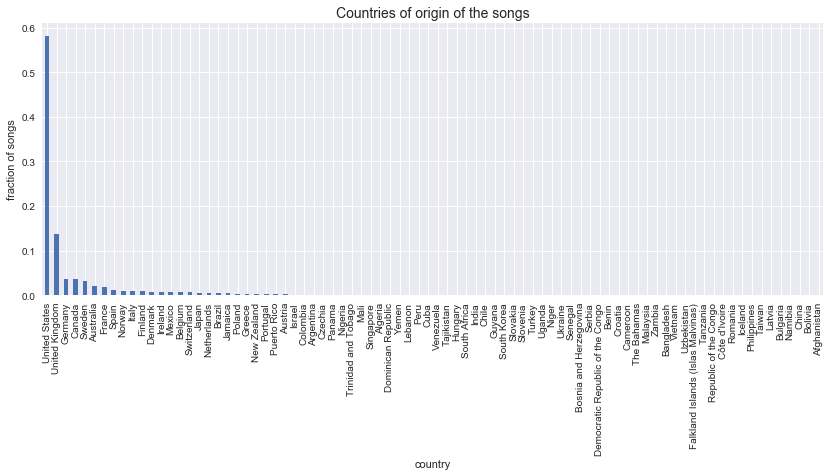

In [407]:
ax = (song_count_per_country['count']/song_count_per_country['count'].sum()).\
                                                sort_values(ascending=False).\
                                                plot(kind='bar', figsize=(14,5))

ax.set_title('Countries of origin of the songs', fontsize=14)
ax.set_xlabel('country')
ax.set_ylabel('fraction of songs')

ax.set_xticklabels(song_count_per_country.sort_values(by='count', ascending=False)['country']);

We now see even more clearly that most of the songs - roughly 60% in fact - come from the United States.
Slightly more than 10% has its origin in the United Kingdom, and a little 4% in Canada.
The top-3 countries are all Anglo-Saxon countries.

There is always he possiblity that the songs for which no geographic coordinates are available all come from countries which are here under-represented, or not at all.
What happened most likely however is that the songs in the Million Song Dataset were selected with a heavy emphasis on artist from these countries.

#### Song hotttnesss
We will now determine whether there is a relationship between the geopgrahic location of the song and its `song hotttnesss`. To this end, we compute the mean `song hotttnesss` per country.

In [402]:
song_hotttnesss_avg_per_country = data_tmp.groupby('country')['country', 'song hotttnesss'].mean().reset_index() #sort_values(ascending=False)
song_hotttnesss_avg_per_country = pd.merge(song_hotttnesss_avg_per_country , country_codes, how='left',
                    left_on=['country'],
                    right_on=['country'])
song_hotttnesss_avg_per_country.head()

,country,song hotttnesss,iso alpha 2 code,iso alpha 3 code,iso numeric code
0,Afghanistan,0.724092,AF,AFG,004
1,Algeria,0.413942,DZ,DZA,012
2,Argentina,0.343779,AR,ARG,032
3,Australia,0.417387,AU,AUS,036
4,Austria,0.372608,AT,AUT,040


In [403]:
def draw_map(song_hotttnesss_avg_per_country):
    lausanne_coord = [46.519962, 6.633597]
    map_world = folium.Map(location=lausanne_coord, tiles='cartodbpositron', zoom_start=2)

    scale = list(song_hotttnesss_avg_per_country['song hotttnesss'].quantile([x * 1/5 for x in range(1, 5)]).values)
    scale = [min(song_hotttnesss_avg_per_country['song hotttnesss'])] + scale + [max(song_hotttnesss_avg_per_country['song hotttnesss'])]

    map_world.choropleth(geo_data=world_topojson, 
                        data=song_hotttnesss_avg_per_country,
                        columns=['iso alpha 3 code', 'song hotttnesss'],
                        threshold_scale=scale,
                        key_on='id',
                        topojson='objects.countries1',
                        fill_color='YlOrBr', fill_opacity=0.6, line_opacity=0.2,
                        legend_name='Average song hotttnesss')

    return map_world
    
draw_map(song_hotttnesss_avg_per_country)

From this map, we can make the following observations:

* 
* 
* 

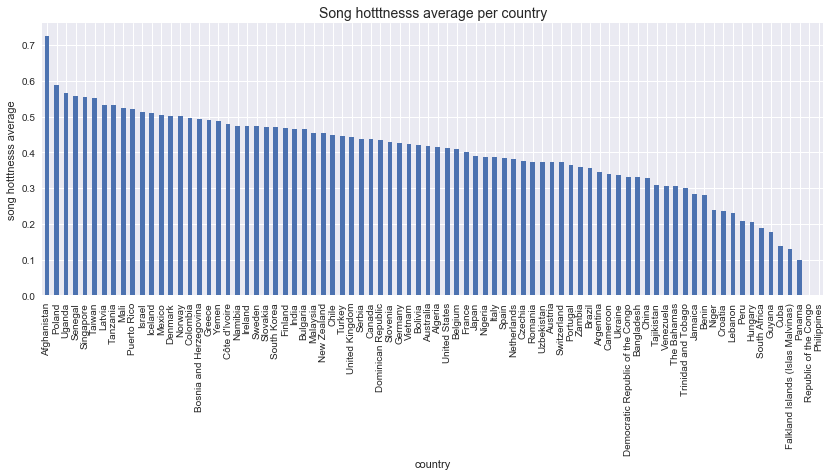

In [212]:
ax = (song_hotttnesss_avg_per_country['song hotttnesss']).\
                                                sort_values(ascending=False).\
                                                plot(kind='bar', figsize=(14,5))

ax.set_title('Song hotttnesss average per country', fontsize=14)
ax.set_xlabel('country')
ax.set_ylabel('song hotttnesss average')

ax.set_xticklabels(song_hotttnesss_avg_per_country.sort_values(by='song hotttnesss', ascending=False)['country']);

We mapped songs to their country of origin using the `artist latitude` and the `artist longitude`, but it turned out only one, two, sometimes three songs actually belong to a given country.
As a consequence, computing the mean `song hotttnesss` for these countries yields unrepresentative results.

For instance, Afghanistan ranks top for the mean `song hotttnesss` per country. 
In the dataset though, there is only a single song for Afghanistan.
By contrast, the United States records 20 376 songs in total (with valid geographic coordinates) - comparing the mean `song hotttnesss` between these two countries would be out of proportion.

In [275]:
print('Number of songs for Afganhistan:', len(data_tmp[data_tmp['country'] == 'Afghanistan']))
print('Number of songs for the United States:', len(data_tmp[data_tmp['country'] == 'United States']))

Number of songs for Afganhistan: 1
Number of songs for the United States: 20376


For this statistic, we therefore only keep entries whose associated country has "enough" recorded songs.

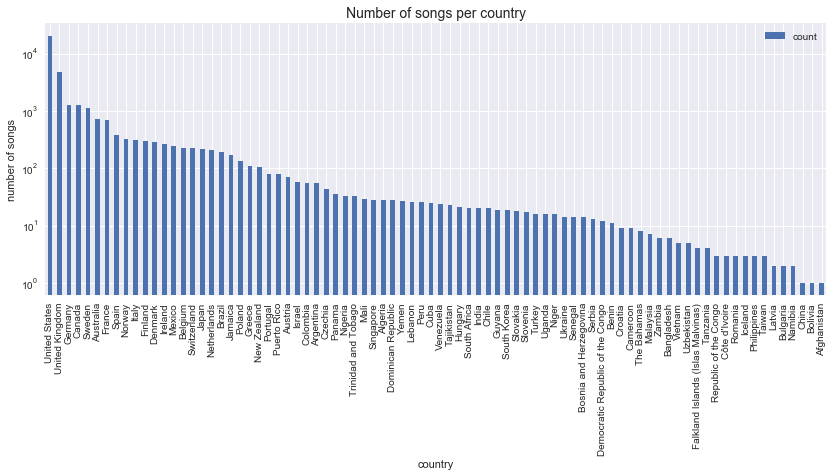

In [290]:
data_tmp_by_country = data_tmp.groupby('country').size().to_frame('count').reset_index()

ax = data_tmp_by_country.sort_values(by='count', ascending=False).plot(kind='bar', figsize=(14,5), logy=True)

ax.set_title('Number of songs per country', fontsize=14)
ax.set_xlabel('country')
ax.set_ylabel('number of songs')

ax.set_xticklabels(tmp.sort_values(by='count', ascending=False)['country']);

In [410]:
threshold = 100
keep_countries = data_tmp_by_country[data_tmp_by_country['count'] >= threshold]['country'].tolist()
print('Number of countries selected:', len(keep_countries), 'out of', len(data_tmp_by_country))

Number of countries selected: 23 out of 82


In [411]:
song_hotttnesss_avg_per_country = data_tmp[(data_tmp['country'].isin(keep_countries)) 
                                         & (data_tmp['song hotttnesss'] > 0.0)].\
                                        groupby('country')['country', 'song hotttnesss'].\
                                        mean().\
                                        sort_values(by='song hotttnesss', ascending=False).\
                                        reset_index()
song_hotttnesss_avg_per_country = pd.merge(song_hotttnesss_avg_per_country , country_codes, how='left',
                    left_on=['country'],
                    right_on=['country'])
song_hotttnesss_avg_per_country.head(10)

,country,song hotttnesss,iso alpha 2 code,iso alpha 3 code,iso numeric code
0,Poland,0.588904,PL,POL,616
1,Denmark,0.544802,DK,DNK,208
2,Greece,0.528571,GR,GRC,300
3,Mexico,0.527520,MX,MEX,484
4,Sweden,0.518744,SE,SWE,752
5,Norway,0.518241,NO,NOR,578
6,Ireland,0.516541,IE,IRL,372
7,Finland,0.491109,FI,FIN,246
8,Canada,0.489833,CA,CAN,124
9,United Kingdom,0.485735,GB,GBR,826


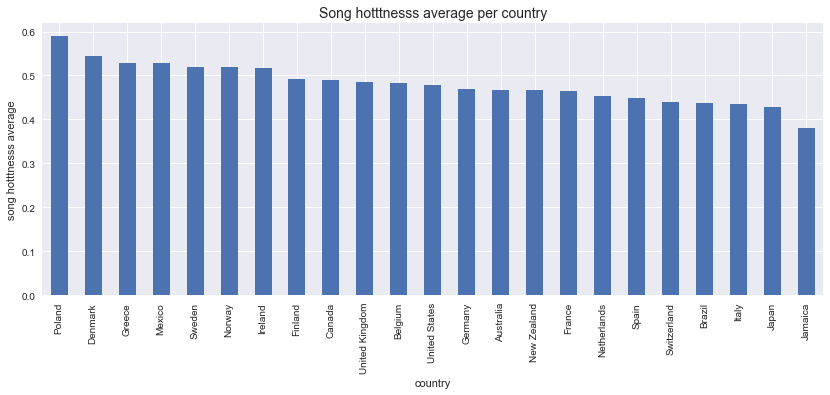

In [412]:
ax = (song_hotttnesss_avg_per_country['song hotttnesss']).\
                                                sort_values(ascending=False).\
                                                plot(kind='bar', figsize=(14,5))

ax.set_title('Song hotttnesss average per country', fontsize=14)
ax.set_xlabel('country')
ax.set_ylabel('song hotttnesss average')

ax.set_xticklabels(song_hotttnesss_avg_per_country.sort_values(by='song hotttnesss', ascending=False)['country']);

In [413]:
draw_map(song_hotttnesss_avg_per_country)

**Observations:**

Unfortunately, by introducing a minimum number of songs per country of, all songs from Africa tend to get lost, as well as most songs from Asia and from Latin America, with the exception of Japan and Brasil.

However, by varying the threshold between relatively low and high values, we also see that the ranking for the average `song hotttnesss` does not change that much either. 

* With a threshold of 240, the top-10 countries are, in decreasing order: Denmark, Mexico, Sweden, Norway, Ireland, Finland, Canada, United Kingdom, United States, Germany.
* With a threshold of 100, the top-10 countries are, in decreasing order: Poland, Denmark, Greece, Mexico, Sweden, Norway, Ireland, Finland, Canada and the United Kingdom.
* With a threshold of 60, the top-10 countries are, in decreasing order: Poland, Denmark, Puerto Rico, Greece, Mexico, Sweden, Norway, Ireland, Finland, Canada.

**Conclusions:**

Pick a Scandinavian country when declaring the artist's country of origin?

### Influence of lyrics on the popularity of a song

Official webpage of the musiXmatch dataset:
https://labrosa.ee.columbia.edu/millionsong/musixmatch
 
* Train set:
http://labrosa.ee.columbia.edu/millionsong/sites/default/files/AdditionalFiles/mxm_dataset_train.txt.zip

* Test set:
http://labrosa.ee.columbia.edu/millionsong/sites/default/files/AdditionalFiles/mxm_dataset_test.txt.zip

* 779k matches:
http://labrosa.ee.columbia.edu/millionsong/sites/default/files/AdditionalFiles/mxm_779k_matches.txt.zip

* Full list of stemmed words:
http://labrosa.ee.columbia.edu/millionsong/sites/default/files/AdditionalFiles/full_word_list.txt.zip
(498,134 unique words, total of 55,163,335 occurrences)

#### Loading the data

In [11]:
path_lyrics = './data/lyrics/'

In [12]:
# load the 'full_word_list.txt' file, containing all the words present in all the songs
# use <encoding='utf-8-sig'> because of some weird oriental characters
full_word_list = pd.read_csv(path_lyrics+'full_word_list.txt', skiprows=7, sep='<SEP>', header=None, engine='python', encoding='utf-8-sig')
full_word_list.columns = ['word', 'count']

print('Number of words:', len(full_word_list))
full_word_list.head()

Number of words: 498134


,word,count
0,i,2078808
1,the,1863782
2,you,1744257
3,to,1067578
4,and,1055748


We immediately see that the top words in the lyrics are in fact the english stopwords 'I', 'the', 'you', 'to', 'and', ..., which is not surprising.

If we look at the last rows of the full list of words though, we see that some of the lyrics actually contain japanese "words":

In [13]:
full_word_list.tail(3)

,word,count
498131,｢ただのマイリー」と,1
498132,｢どうしたんだ｣と聞いた,1
498133,｢何を考えてる｣って,1


In fact, the Million Song Dataset seems to contain songs with lyrics written in many more languages than just English: by scrolling through the `full_word_list.txt` file, one can stop words which definitely do not come from English!

Unfortunately, such songs are very sparse - the word count actually indicates 1 for each japanese "word" in the list. This makes it very dificult to use them in the lyrics analysis.
But in any case, they do not appear in the top-5000 words kept in the `mxm_dataset_train.txt` and the `mxm_dataset_test.txt` datasets, so we will not concern ourselves further with them.

We will now load the top-5000 most frequent words overall the lyrics.

In [159]:
# load the top-5000 words
top_words_list = []

# the top-5000 words can be found after the line starting with '%' in the 'mxm_dataset_train.txt' file
with open(path_lyrics+'mxm_dataset_train.txt', encoding='utf-8-sig') as f:
    for line in f:
        if line.startswith('%'):
            top_words_list = line[1:] # drop the '%' marking the beginning of the line
            break

top_words_list = top_words_list.split(',')
print('Number of words:', len(top_words_list))
top_words_list[0:10]

Number of words: 5000


['i', 'the', 'you', 'to', 'and', 'a', 'me', 'it', 'not', 'in']

As observed just previously, many of the top-5000 words seem the be stopwords. 
This can't be helped though, since stopwords are indeed the most frequent words in practice.

By definition, stopwords are words that bear little meaning, in particular for search queries, and which are therefore often removed during the preprocessing step.
However, there are two reasons we will not remove the stopwords from our lyrics analysis:
* The first one is that we are not dealing with search queries.
* The second one is because songs are intrinsically based on repetitive patterns, even more than prose, so that some of these stopwords can actually be considered as an important part of the lyrics.

We now load the musiXmatch matches from the both the `mxm_dataset_train.txt` dataset and the `mxm_dataset_test.txt` dataset.
Since we are not going to do any prediction task, we simply use both datasets as one single dataset.

In [15]:
def load_mxm_dataset(filename):
    
    entries = []
    with open(path_lyrics+filename) as f:
        # skip the first 18 lines
        lines = f.readlines()[18:] 
        for line in lines:
            line = line.split(',')

            entry = []
            entry.append(line[0])
            entry.append(line[1])

            words = {}
            line = line[2:]
            for item in line:            
                words[int(item.split(':')[0])] = int(item.split(':')[1])
            entry.append(words)

            entries.append(entry)
    
    return entries

In [16]:
# load the 'mxm_dataset_train.txt' file
filename = 'mxm_dataset_train.txt'
entries = load_mxm_dataset(filename)

# load the 'mxm_data_set_test.txt' file
filename = 'mxm_dataset_test.txt'
entries.extend(load_mxm_dataset(filename))

print('Number of songs:', len(entries))

Number of songs: 237662


The musiXmatch dataset provides a matching between 779056 songs of the Million Song Dataset, but in total, there are only 237 662 (train set: 210 519, test set: 27 143) songs whose lyrics are provided (as a bag-of-word).
This means that at most this number of songs can be used for the lyrics analysis.

In [17]:
mxm_dataset = pd.DataFrame(entries)
mxm_dataset.columns = ['track id', 'mxm track id', 'words']
mxm_dataset.head()

,track id,mxm track id,words
0,TRAAAAV128F421A322,4623710,"{1: 6, 2: 4, 3: 2, 4: 2, 5: 5, 6: 3, 7: 1, 8: ..."
1,TRAAABD128F429CF47,6477168,"{1: 10, 3: 17, 4: 8, 5: 2, 6: 2, 7: 1, 8: 3, 9..."
2,TRAAAED128E0783FAB,2516445,"{1: 28, 2: 15, 3: 2, 4: 12, 5: 22, 6: 2, 7: 2,..."
3,TRAAAEF128F4273421,3759847,"{1: 5, 2: 4, 3: 3, 4: 2, 5: 1, 6: 11, 9: 4, 12..."
4,TRAAAEW128F42930C0,3783760,"{1: 4, 4: 5, 5: 7, 6: 2, 7: 4, 9: 1, 10: 1, 11..."


In [18]:
# load the 'mxm_779k_matches.txt' file
mxm_779k_matches = pd.read_csv(path_lyrics+'mxm_779k_matches.txt', skiprows=18, sep='<SEP>', header=None, engine='python')
mxm_779k_matches.columns = ['track id', 'artist name', 'title', 'mxm track id', 'mxm artist name', 'mxm title']

print('Number of songs matched:', len(mxm_779k_matches))
mxm_779k_matches.head()

Number of songs matched: 779056


,track id,artist name,title,mxm track id,mxm artist name,mxm title
0,TRMMMKD128F425225D,Karkkiautomaatti,Tanssi vaan,4418550,Karkkiautomaatti,Tanssi vaan
1,TRMMMRX128F93187D9,Hudson Mohawke,No One Could Ever,8898149,Hudson Mohawke,No One Could Ever
2,TRMMMCH128F425532C,Yerba Brava,Si Vos QuerÃ©s,9239868,Yerba Brava,Si vos queres
3,TRMMMXN128F42936A5,David Montgomery,"Symphony No. 1 G minor ""Sinfonie Serieuse""/All...",5346741,Franz Berwald,"Symphony No. 1 in G minor ""Sinfonie SÃ©rieuse""..."
4,TRMMMBB12903CB7D21,Kris Kross,2 Da Beat Ch'yall,2511405,Kris Kross,2 Da Beat Ch'yall


We now merge the 779k matched songs with their correspondong `song hotttnesss` and `words` bag of words.

In [19]:
mxm_matches = mxm_779k_matches.merge(data[['track id', 'song hotttnesss']])
print('Number of songs matched in MSD:', len(mxm_matches))

mxm_matches = mxm_matches.merge(mxm_dataset[['track id', 'words']])
print('Number of songs matched in musiXmatch:', len(mxm_matches))

#mxm_779k_matches = mxm_779k_matches[['track id', 'artist name', 'title', 'words']]
mxm_matches = mxm_matches.drop(['mxm track id', 'mxm artist name', 'mxm title'], axis=1)
mxm_matches.head(1)

Number of songs matched in MSD: 154663
Number of songs matched in musiXmatch: 60146


,track id,artist name,title,song hotttnesss,words
0,TRGMMCD128F4244A89,Luka Bloom,Soshin,0.405116,"{1: 5, 2: 14, 3: 2, 4: 6, 5: 3, 6: 3, 7: 1, 9:..."


We see that there are indeed 154 663 songs matched between the musiXmatch ID dataset and the Million Song Dataset, and in the end, 60 146 songs matched between the Million Song Dataset and the musiXmatch bag-of-words lyrics dataset.

#### Analysis

We want to find out if there are certain words popular songs (i.e. with a high `song hotttnesss` value) tend to contain more frequently than songs with an average rating. 

In [44]:
threshold = 0.9
top_mxm_matches = mxm_matches[mxm_matches['song hotttnesss'] > threshold]
words_dict_list = top_mxm_matches['words'].tolist()
nb_words = len(set((flatmap([d.keys() for d in words_dict_list]))))
nb_words

top_words = pd.DataFrame()
top_words['word id'] = (list(set(flatmap([d.keys() for d in words_dict_list]))))

In [113]:
from collections import defaultdict

def create_top_words_ranking(threshold, sort_by, verbose=False):
    top_mxm_matches = mxm_matches[mxm_matches['song hotttnesss'] >= threshold]

    # get all the words in the top songs, according to the threshold 
    words_dict_list = top_mxm_matches['words'].tolist()

    # count the number of words over these songs
    nb_words = len((flatmap([d.keys() for d in words_dict_list])))
    
    if(verbose):
        print('Song hotttnesss threshold:', threshold)
        print('Number of songs selected:', len(top_mxm_matches))
        print('Number of words:', nb_words)

    top_words = pd.DataFrame()
    top_words['word id'] = (list((flatmap([d.keys() for d in words_dict_list]))))

    # count the number of songs containing this word
    top_words = top_words.groupby(['word id']).size().to_frame('song count').reset_index()
    #top_words.rename(columns={0:'song count'}, inplace=True)
    
    # count the total number of occurences by word
    #top_words['total count'] = top_words['word id'].apply(lambda key: sum([d[key] for d in words_dict_list if key in d]))
    word_occurences = defaultdict(int)
    for entry in words_dict_list:
        for key in entry:
            word_occurences[key] += entry[key]
           
    top_words['total count'] = top_words['word id'].map(word_occurences)
    
    # compute the frequency of each word
    top_words['frequency'] = top_words['total count'].apply(lambda count: count/(1.0*nb_words))
    
    # map each word id to the acual corresponding word
    top_words['word'] = top_words['word id'].apply(lambda row: top_words_list[row-1])
   
    # reorder the columns
    top_words = top_words.reindex_axis(['word id', 'word', 'song count', 'total count', 'frequency'], axis=1)
    
    # sort the words according to their frequency, in descending order
    top_words = top_words.sort_values(sort_by, ascending=False).reset_index(drop=True)
    
    #rank = []
    #previous_rank = 1
    #previous = top_words[sort_by][0]
    #for item in top_words[sort_by]:
    #    if(item == previous):
    #       rank.append(previous_rank)
    #    else:
    #        rank.append(previous_rank + 1)
    #        previous_rank += 1
    #        previous = item
    
    #top_words['rank'] = rank
    
    return top_words

In [114]:
threshold = 0.9
create_top_words_ranking(threshold, 'song count', True).head(10)

Song hotttnesss threshold: 0.9
Number of songs selected: 284
Number of words: 23490


,word id,word,song count,total count,frequency
0,2,the,260,2578,0.109749
1,5,and,247,1702,0.072456
2,4,to,241,1569,0.066794
3,1,i,241,3599,0.153214
4,3,you,236,3042,0.129502
5,8,it,226,1417,0.060324
6,6,a,223,1298,0.055258
7,9,not,215,1228,0.052278
8,12,is,210,884,0.037633
9,10,in,204,859,0.036569


If we sort the words by the number of songs which contain at least one occurence of this word, then we see that the word 'the' is ranked first, just like in the english word frequency.

Here however, we only counted the number of songs containing a certain word, and did not take into account the actual number of occurences of this word.
Moreover, stopwords are very likely to be consistently present in almost every songs. 
With an increasing `song hotttnesss` threshold, the number of selected songs decreases, and so does the number of distinct words. 
Hence, chances that the very common stopwords 'the', 'you', 'I', ... are placed in the top positions may be in the end only due to the fact that the lexical field decreases in size.
Ranking the words by song count provides some information, but may then not be the best approach.

We therefore try to rank the words by frequency over all selected songs, that is, by taking the total number of occurences of the word and dividing it by the total number of words.
The idea is that the frequency of some stopwords such as 'the', 'to', ... will not vary much with the `song hotttnesss`, while other may actually do so.

In [85]:
threshold = 0.8
create_top_words_ranking(threshold, 'frequency', True).head(10)

Song hotttnesss threshold: 0.8
Number of songs selected: 2060
Number of words: 174967


,word id,word,song count,total count,frequency
0,1,i,1765,24329,0.139049
1,3,you,1738,20693,0.118268
2,2,the,1897,19650,0.112307
3,5,and,1772,12239,0.069950
4,4,to,1776,10923,0.062429
5,8,it,1589,10004,0.057176
6,6,a,1616,9382,0.053622
7,9,not,1522,8908,0.050912
8,7,me,1439,8380,0.047895
9,10,in,1549,6428,0.036738


Unsurprisingly, just like before, the same stopwords 'I', 'you', 'the', 'to', ... are ranked at the top positions. 
But with this approach, the word 'the' is not ranked first anymore.

What is interesting as well is that the word 'you', which is ranked 14th in the english word frequency, has a much higher frequency in the popular songs.
Inversely, the word 'the', which is ranked first in the english word frequency, is ranked "only" XXX.

We also see that 'you' is placed before 'I', whereas 'I' is ranked 11th for the word frequency in English.
Therefore, in order to make a song popular, it seems to be preferable for it to talk more about 'you' than 'I'!

---
The English word frequency of a word can be found at https://www.wordandphrase.info/frequencyList.asp (as a list) or also at https://www.wordfrequency.info/free.asp?s=y (by querying the word).

*(to complete when more data)*

In [73]:
def get_word_frequency(word, ranking):
    if len(top_words_ranking) > 0:
        if(len(ranking[ranking['word'] == word]['frequency'].values) == 0):
            return float('NaN')
        else:
            return ranking[ranking['word'] == word]['frequency'].values[0]
    else:
        return float('NaN')

In [124]:
# define the threshold for the 'song hotttnesss'
thresholds = np.arange(0.0, 1.0, 0.02)

words_list = ['you', 'i', 'we', 'the', 'and', 'is', 'to', 'my', 'your']
#words_list = ['you', 'i', 'we', 'the']
word_ranks_dict = {}

for word in words_list:
    word_ranks_dict[word] = []

for threshold in thresholds:
    top_words_ranking = create_top_words_ranking(threshold, 'frequency', False)
    for word in words_list:
        frequency = get_word_frequency(word, top_words_ranking)
        word_ranks_dict[word].append(frequency)

In [125]:
# to add a single word in words_ranks_dict
word = 'love'
word_ranks_dict[word] = []

for threshold in thresholds:
    top_words_ranking = create_top_words_ranking(threshold, 'frequency', False)
    frequency = get_word_frequency(word, top_words_ranking)
    word_ranks_dict[word].append(frequency)

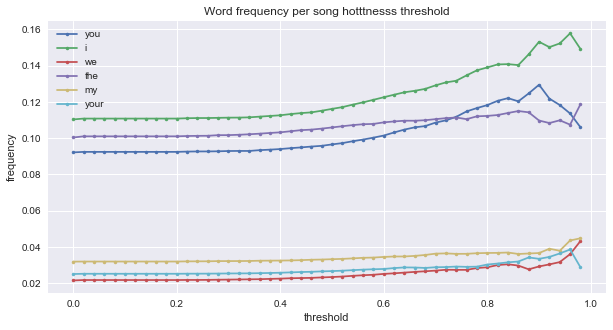

In [133]:
figure()
plt.figure(figsize=(10,5))

#words_list = ['you', 'i', 'the', 'to', 'is', 'we', 'my', 'your']
words_list = ['you', 'i', 'we', 'the', 'my', 'your']
for word in words_list:
    plt.plot(thresholds, word_ranks_dict[word], linestyle='-', marker='.')
#plt.gca().invert_yaxis()
plt.title('Word frequency per song hotttnesss threshold')
plt.xlabel('threshold')
plt.ylabel('frequency')
plt.legend(labels=words_list)

plt.show()

*(Yeah well, some trend, but not super conclusive... we need more data...!)*

Unfortunately, when the `song hotttnesss` threshold increases, less and less songs are selected.
Only XXX songs have a `song hotttnesss` greater or equal than 0.9, and there is only a single song with the highest `song hotttnesss`.
Therefore, it is difficult to formulate an interpretation out of the frequencies for the last couple of threshold values.

Drop around 0.9: possibly not enough data for songs with a `song hotttnesss` > 0.9

To make sure the frequency of words such as X, X or X indeed increases with the `song hotttnesss`, and not that popular songs just have fewer words, we also analyse these frequencies individually for each songs.

In [134]:
mxm_matches.head()

,track id,artist name,title,song hotttnesss,words
0,TRGMMCD128F4244A89,Luka Bloom,Soshin,0.405116,"{1: 5, 2: 14, 3: 2, 4: 6, 5: 3, 6: 3, 7: 1, 9:..."
1,TRGMMLA128F931B914,Jimmie Dale Gilmore,Because of the Wind (LP Version),0.334707,"{1: 3, 2: 23, 3: 8, 4: 2, 5: 4, 7: 3, 10: 1, 1..."
2,TRGMMJZ128F9343BBC,Strung Out,The Misanthropic Principle,0.617991,"{1: 8, 2: 8, 3: 5, 4: 7, 5: 4, 6: 3, 7: 4, 8: ..."
3,TRGMMME128F9308071,IQ,Sleepless Incidental,0.508801,"{1: 3, 2: 11, 4: 5, 5: 7, 6: 1, 9: 2, 10: 6, 1..."
4,TRGMWGB128F147C328,Sophie B. Hawkins,I Walk Alone (Bonus Track),0.000000,"{1: 33, 2: 2, 3: 6, 4: 16, 5: 4, 6: 1, 7: 3, 8..."


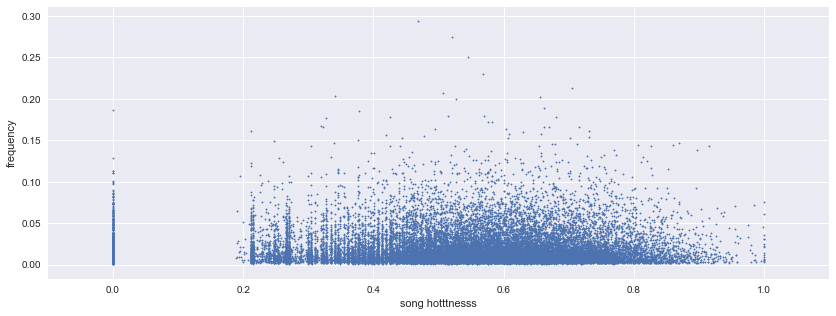

In [142]:
word = 'we'
word_id = top_words_list.index(word) + 1 # word indices start at 1 in the musiXmatch dataset

tmp = mxm_matches.copy()
tmp['count'] = mxm_matches['words'].apply(lambda word_dict: word_dict[word_id] if word_id in word_dict else 0)
tmp = tmp[tmp['count'] != 0]
tmp['length'] = mxm_matches['words'].apply(lambda word_dict: sum([word_dict[key] for key in word_dict]))
tmp['frequency'] = tmp['count'] / tmp['length'] 

tmp.head()
ax = tmp.plot.scatter(x='song hotttnesss', y='frequency', s=2, figsize=(14,5))
ax.set_xlim((-0.1, 1.1));

In [368]:
full_word_list.head()

,word,count
0,i,2078808
1,the,1863782
2,you,1744257
3,to,1067578
4,and,1055748


#### Lyrics length (estimated)

We estimate the length the lyrics for a song by summing all the occurences. 
Since only the occurences of the top-5000 words are available, this will only be an estimation of the actual lyrics length though.

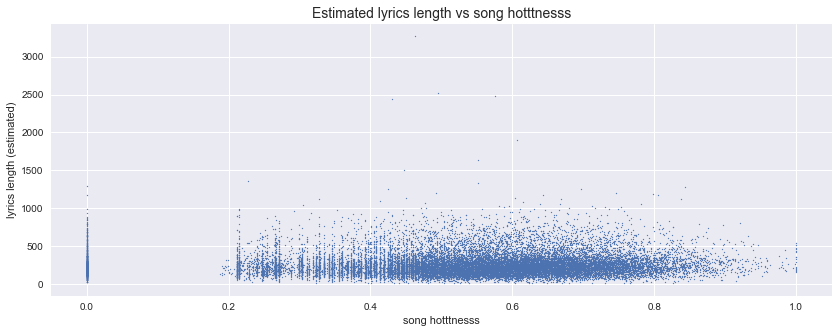

In [144]:
ax = tmp.plot.scatter(x='song hotttnesss', y='length', s=1, figsize=(14,5))
ax.set_title('Estimated lyrics length vs song hotttnesss', fontsize=14)
ax.set_xlabel('song hotttnesss')
ax.set_ylabel('lyrics length (estimated)');

#### A look at the not-so-popular songs

In this section, we want to find out whether there are words that are only present in popular songs or in not-so-popular songs.

To do this, we collect two sets of words (always among the top-5000 most frequent ones): the ones for the songs with a `song hotttnesss` above a certain threshold (popular songs) and the ones for songs with a `song hotttnesss` under a certain threshold (not-so-popular songs).

We then take the difference between the set of words of popular songs and the set of words of not-so-popular songs for finding words present only in popular songs, and vice-versa for finding words present only in not-so-popular songs.

In [194]:
#intersection popular songs / crappy songs
tmp = mxm_matches.copy()
head_threshold = 0.9
tail_threshold = 0.2
head = tmp[tmp['song hotttnesss'] > head_threshold]
tail = tmp[(tmp['song hotttnesss'] < tail_threshold) & (tmp['song hotttnesss'] > 0.0)]
tail = tmp[(tmp['song hotttnesss'] < tail_threshold)]

tail_words = set(flatmap([d.keys() for d in tail['words']]))
head_words = set(flatmap([d.keys() for d in head['words']]))

print('Number of songs with a song hotttnesss >', head_threshold, ':', len(head))
print('Number of songs with a song hotttnesss <', tail_threshold, ':', len(tail))
print('Number of words in common:', len(head_words.intersection(tail_words)))
print('Number of words only in songs with a song hotttnesss > ', head_threshold, ':', len(head_words.difference(tail_words)))
print('Number of words only in songs with a song hotttnesss < ', tail_threshold, ':', len(tail_words.difference(head_words)))

Number of songs with a song hotttnesss > 0.9 : 284
Number of songs with a song hotttnesss < 0.2 : 3145
Number of words in common: 2654
Number of words only in songs with a song hotttnesss >  0.9 : 5
Number of words only in songs with a song hotttnesss <  0.2 : 2317


In [195]:
print(list(map(lambda x: top_words_list[x-1], head_words.difference(tail_words))))
print(list(map(lambda x: top_words_list[x-1], tail_words.difference(head_words))))

['we’r', 'structur', 'forg', 'hypocrit', 'ainda']
['mi', 'ich', 'lo', 'und', 'les', 'al', 'non', 'nicht', 'las', 'das', 'dan', 'quiero', 'ist', 'ja', 'cest', 'su', 'ni', 'cuando', 'mich', 'va', 'zu', 'más', 'jag', 'wir', 'mir', 'lyric', 'bien', 'dich', 'per', 'vez', 'sie', 'det', 'mon', 'voy', 'siempr', 'wie', 'soy', 'au', 'auf', 'comm', 'evil', 'dem', 'ho', 'une', 'mit', 'och', 'tan', 'hoy', 'è', 'sur', 'mein', 'dir', 'tengo', 'jai', 'ik', 'beyond', 'nur', 'tú', 'doch', 'tanto', 'pa', 'wenn', 'dein', 'san', 'tien', 'io', 'nous', 'dond', 'poor', 'destroy', 'mar', 'vie', 'sa', 'ei', 'van', 'toi', 'entr', 'für', 'bin', 'refrain', 'corazón', 'cada', 'ere', 'von', 'ba', 'ahora', 'är', 'alma', 'ça', 'cielo', 'hasta', 'cosa', 'bye', 'doo', 'mes', 'più', 'sein', 'på', 'sind', 'x2', 'wound', 'otra', 'hace', 'toda', 'ihr', 'mano', 'realiti', 'quier', 'nadi', 'fue', 'hier', 'vas', 'sui', 'sen', 'dentro', 'mehr', 'sich', 'kein', 'rien', 'nie', 'aus', 'tes', 'fait', 'het', 'poi', 'siento', 'qué', 

In [ ]:
# - much more words in crappy songs not in popular songs than the reverse
# - some "crappy" songs are actually not written in English (Spanish, ...)
# - still not clear whether song hotttnesss of 0.0 means crappy
# - could still indicate a huge biais when song hotttnesss was rated (i.e. users rated mostly English songs)
#   in fact, all "popular songs" are in English


## Features or combination of features making a song popular

### Song duration

In [1684]:
describe(data, 'duration', True)

,duration
count,159430.000000
mean,245.452216
std,111.820937
min,0.678730
25%,185.135870
50%,230.686890
75%,284.185670
max,3007.738320


In [1697]:
describe(data_subset, 'duration', True)

,duration
count,10000.000000
mean,238.507278
std,114.137314
min,1.044440
25%,176.032196
50%,223.059143
75%,276.375061
max,1819.767700


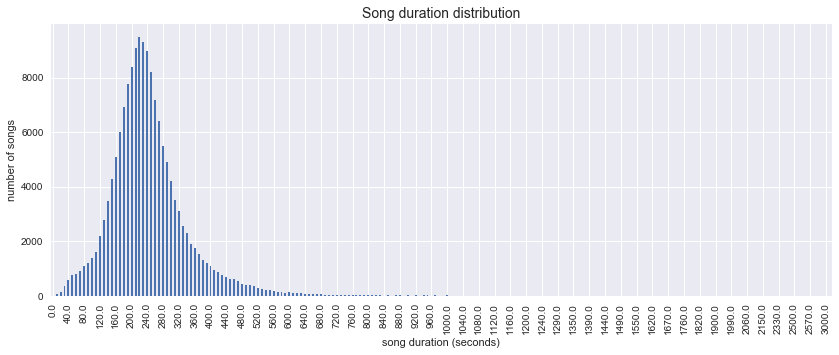

In [1685]:
ax = round(data['duration'], -1).value_counts()\
                                .sort_index()\
                                .plot(kind='bar', 
                                      grid=True,
                                      figsize=(14, 5));
        
ax.set_title('Song duration distribution', fontsize=14)
ax.set_xlabel('song duration (seconds)')
ax.set_ylabel('number of songs')
set_ticks_wtih_step(ax, 4)

When using more songs, we the song duration distribution becomes squeezed to the left, because of the apparition of outliers: the maximal duration is 3007 seconds (50min 7s) whereas previously, it was only 1819 seconds (30min 19s).

The mean song average is relatively stable though, with a mean song duration of 245s for the subset, and 238s for the dataset.

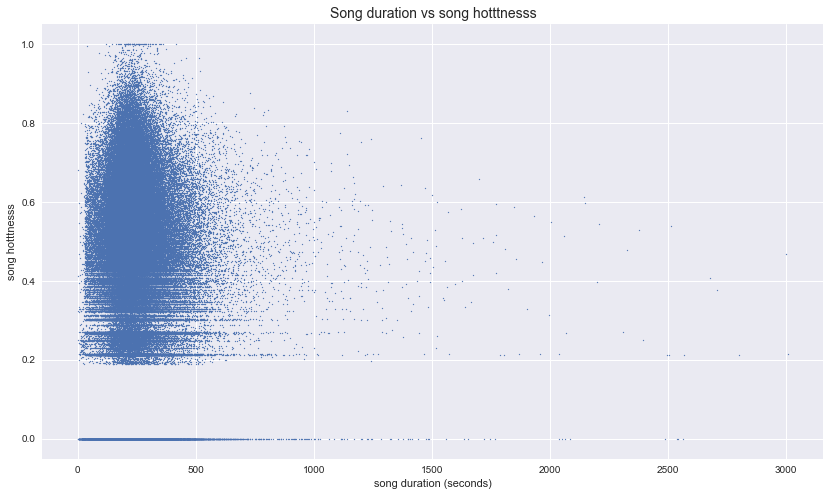

In [1877]:
ax = data.plot.scatter(x='duration', y='song hotttnesss', s=1, figsize=(14,8), grid=True);
ax.set_title('Song duration vs song hotttnesss', fontsize=14)
ax.set_xlabel('song duration (seconds)')
ax.set_ylabel('song hotttnesss');

A trend which was not so visible with the subset is the decreasing `song hotttnesss` with the increasing song duration.

Moreover, it becomes clear there is a song duration intervall during which all songs with `song hotttnesss` of 1.0, or close to 1.0 can be found.
Of course, there is also a great deal of songs in this interval which do not have a high `song hotttnesss` value; in fact, the XXX% of the song durations fall within this intervall, with a `song hotttnesss` ranging from 0.0 to 1.0.

It is still unclear though whether a `song hotttnesss` of 0.0 effectively corresponds to a 0.0, or was just not evaluated. In the documentation, `NaN` values correspond to a non-evaluated `song hotttnesss`, but due to the apparent gap between 0.0 and 0.2, this assumption becomes questionable.

In [1795]:
threshold = 1.0
print('Number of songs with a song hotttnesss >=', threshold, ':', len(data[data['song hotttnesss'] >= threshold]))

threshold_low = min(data[data['song hotttnesss'] >= threshold]['duration'])
threshold_high = max(data[data['song hotttnesss'] >= threshold]['duration'])
print('Proportion of songs with a duration between', threshold_low, 's and', threshold_high, 's:', round(len(data[(data['duration'] >= threshold_low) & (data['duration'] <= threshold_high)]) / len(data) * 100, 2), '%')

describe(data[data['song hotttnesss'] >= threshold], 'duration', True)

Number of songs with a song hotttnesss >= 1.0 : 63
Proportion of songs with a duration between 120.63302 s and 418.14159 s: 88.2 %


,duration
count,63.000000
mean,251.190943
std,55.567511
min,120.633020
25%,214.752200
50%,239.046080
75%,285.361180
max,418.141590


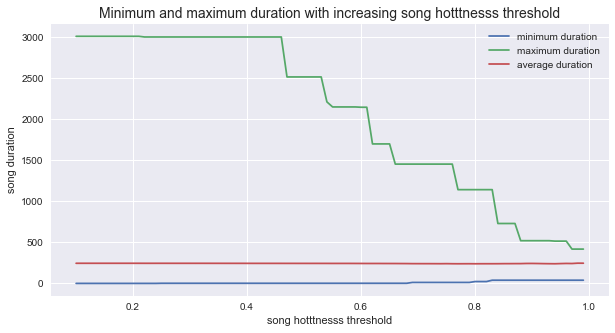

In [1878]:
thresholds = np.arange(0.1, 1.0, 0.01)
min_durations = []
max_durations = []
avg_durations = []
for threshold in thresholds:
    min_durations.append(min(data[data['song hotttnesss'] >= threshold]['duration']))
    max_durations.append(max(data[data['song hotttnesss'] >= threshold]['duration']))
    avg_durations.append((data[data['song hotttnesss'] >= threshold]['duration']).mean())

figure()
plt.figure(figsize=(10,5))

plt.plot(thresholds, min_durations)
plt.plot(thresholds, max_durations)
plt.plot(thresholds, avg_durations)
plt.title('Minimum and maximum duration with increasing song hotttnesss threshold', fontsize=14)
plt.xlabel('song hotttnesss threshold')
plt.ylabel('song duration')
plt.legend(labels=['minimum duration', 'maximum duration', 'average duration']);

**Conclusion:** 
* if you want your song to be "hot", don't make it longer than 419 seconds (6min 59s) (which is actually pretty long already, if one thinks about it...)
* on average though, 251 seconds (4min 11s) should maximize the chances it is rated "hot".

*Over the years...*

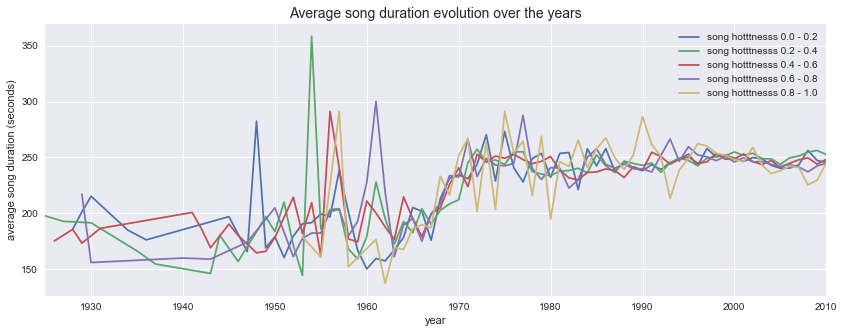

In [1937]:
#threshold = 0.8
#ax = data[data['song hotttnesss'] >= threshold].groupby('year')['duration'].min().plot(figsize=(14,5))
#data[data['song hotttnesss'] >= threshold].groupby('year')['duration'].max().plot()

step = 0.2
thresholds = np.arange(0.0, 1.0, step)

for threshold in thresholds:
    ax = data[(data['song hotttnesss'] >= threshold) 
              & (data['song hotttnesss'] < threshold + step if threshold < 0.8 else data['song hotttnesss'] <= threshold + step) 
              & (data['year'] < 2011)].groupby('year')['duration'].mean().plot(figsize=(14,5))
# we exclude songs with the 'year' 2011, because there are too few of them (and then the plot is not so pretty)

ax.set_title('Average song duration evolution over the years', fontsize=14)
ax.set_xlabel('year')
ax.set_ylabel('average song duration (seconds)')
#ax.legend(labels=['mininum', 'maximum', 'average']);
ax.legend(labels=['song hotttnesss ' + str(t) + ' - ' + str(t+step) for t in thresholds]);

**Observations:**
* too few songs before 1960, so difficult to evaluate
* great variation for the average duration of the hotttessst songs between ~1970 and ~1995
* seems to stabilize after 1995: all songs, regardless of their `song hotttnesss`, seem to converge to the same average duration
* actually, after 2003 "hot" songs tend to be slightly shorter than the average
* which suggests that either
  * the number of "hot" songs significantly increased, thus homogenizing the average song duration for "hot" songs
  * song with a duration greater than XXX tend to now be known by a wide public, and hence have much less chance to be rated "hot"
  * to be "hot", a song has to comply more and more to some standard song duration
  

### Artist hotttnesss

In [440]:
# group by 'artist name' and take the average of the 'song hotttnesss's
artist_song_hotttnesss_avg = data.groupby('artist name')['artist name', 'song hotttnesss'].mean().reset_index()
artist_song_hotttnesss_avg.rename(columns = {'song hotttnesss':'song hotttnesss average'}, inplace=True)

print('Number of rows:', len(artist_song_hotttnesss_avg))
artist_song_hotttnesss_avg.head()

Number of rows: 24033


,artist name,song hotttnesss average
0,!!!,0.000000
1,!Deladap,0.641668
2,#Poundsign#,0.190498
3,$jammie the Money,0.000000
4,$tinkworx,0.277252


In [447]:
# keep the 'artist name' and the 'artist hotttnesss'
artist_hotttnesss = data[['artist name', 'artist hotttnesss']].drop_duplicates().reset_index(drop=True)

print('Number of rows:', len(artist_song_hotttnesss_avg))
artist_hotttnesss.head()

Number of rows: 24033


,artist name,artist hotttnesss
0,Planet P Project,0.332276
1,Adelitas Way,0.461318
2,Chaka Khan_ Rufus,0.398984
3,Western Addiction,0.386606
4,International Noise Conspiracy,0.414283


The number of artists matches in both dataframes, which means there is *a priori* no need to take the mean `artist hotttesss` for some artists.

In [459]:
#artist_hotttnesss = pd.DataFrame(artist_hotttnesss.groupby('artist name')['artist hotttnesss'].mean()).reset_index()
#print('Number of rows:', len(artist_song_hotttnesss_avg))
#artist_hotttnesss.head()

In [456]:
df = pd.merge(artist_hotttnesss , artist_song_hotttnesss_avg, on='artist name', how='left')

print('Number of rows matched:', len(df))
df.head()

Number of rows matched: 24033


,artist name,artist hotttnesss,song hotttnesss average
0,!!!,0.482131,0.000000
1,!Deladap,0.389536,0.641668
2,#Poundsign#,0.525509,0.190498
3,$jammie the Money,0.000000,0.000000
4,$tinkworx,0.367140,0.277252


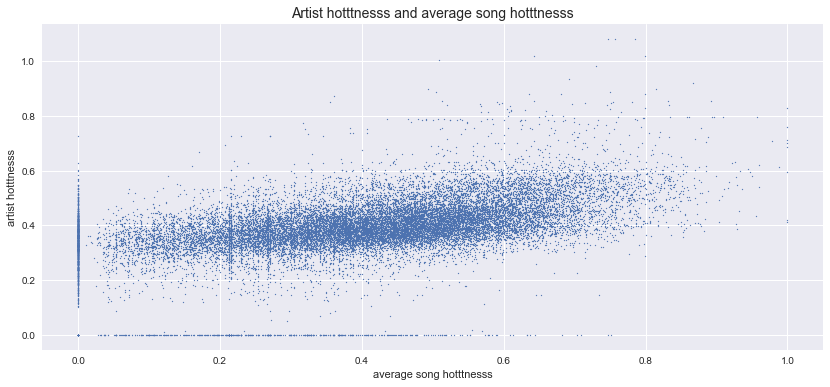

In [457]:
ax = df.plot.scatter(x='song hotttnesss average', y='artist hotttnesss', s=1, figsize=(14, 6));
ax.set_title('Artist hotttnesss and average song hotttnesss', fontsize=14)
ax.set_xlabel('average song hotttnesss')
ax.set_ylabel('artist hotttnesss');

**Observations:**

There is definitely a correlation between the `song hotttnesss` of a song, and the corresponding `artist hotttnesss`.
What remains unclear though is whether one causes the other or not...

However, the hotttessst artists do not seem to lead to the hotttessst songs either, as can be seen for artists with an `artist hotttnesss` greater than 1.0.

**Conclusion:**

Not so good news for a beginner artist not yet rated "hot". On average, the artist of a song with a high `song hotttnesss` value tends to have a high `artist hotttnesss` as well.



#### Energy
Still not evaluated, why?

In [1696]:
describe(data, 'energy', True)

,energy
count,159430.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


#### Danceability

Same, also not evaluated

In [1682]:
describe(data, 'danceability', True)

,danceability
count,159430.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


### Evolution over time of features making a song popular